<a href="https://www.kaggle.com/code/pedrosoares1412/walmart-sales-prediction?scriptVersionId=175882203" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1.0 Imports

In [136]:
import pandas              as pd
import numpy               as np
import seaborn             as sns
import matplotlib.pyplot   as plt
import os
import datetime
import xgboost             as xgb

from boruta                  import BorutaPy
from scipy                   import stats as ss
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble        import RandomForestRegressor
from sklearn.metrics         import mean_absolute_error, mean_squared_error
from sklearn.linear_model    import LinearRegression, Lasso
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [137]:
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [30, 20]
plt.rcParams['font.size'] = 25



# 2.0 Statitistical analysis

In [138]:
#Descritivo das variaveis
#We will study the sales data of one of the largest retailers in the world. Let's figure out what factors influence its revenue. Can factors such as air temperature and fuel cost influence the success of a huge company along with the purchasing power index and seasonal discounts? And how does machine learning minimize costs and increase economic impact?

#The data contains the following columns:

# - Store: Store number
# - Date: Sales week start date
# - Weekly_Sales: Sales
# - Holiday_Flag: Mark on the presence or absence of a holiday
# - Temperature: Air temperature in the region
# - Fuel_Price: Fuel cost in the region
# - CPI: Consumer price index
# - Unemployment: Unemployment rate

In [139]:
# Opening CSV
df = pd.read_csv('https://raw.githubusercontent.com/pedroesoares/Walmart-Sales/main/Walmart_sales.csv')
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


In [140]:
#Descrição estatística dos dados
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [ ]:
#Df Types and Df is na
df.sum().isna()

Store           False
Date            False
Weekly_Sales    False
Holiday_Flag    False
Temperature     False
Fuel_Price      False
CPI             False
Unemployment    False
dtype: bool

In [ ]:
df.dtypes

In [ ]:
num_attributes = df.select_dtypes(include=['int64', 'float64'])
num_attributes.drop('Store', axis=1, inplace=True)


In [ ]:
# Dispersion - desvio padrão, min, max, range, skew and kurtosis

d1 = pd.DataFrame( num_attributes.apply(np.std)).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame( num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame( num_attributes.apply(lambda x: x.kurtosis())).T

#Concatenar dados

metricas = pd.concat( [d2, d3, d4, d1, d5, d6] ).T.reset_index()
metricas.columns = ['Attributes', 'Min', 'Max', 'Median', 'std', 'Skew', 'Kurtosis']

In [ ]:
metricas

In [ ]:
df.rename(columns={'Weekly_Sales':'Sales'},inplace=True)

# 3.0 Exploratory analisys

## Hypothesis
1. Stores should sell more in Holidays rather than normal days / weeks. 
2. Sales should be higher when Unemployment rate is lower.
3. Stores where fuel price is lower should have higher sales.
4. Diferent Stores should have diferent types of sales.
5. Moments of higher CPI (Consumer Price Index) should be lower on sales.

In [ ]:

#sns.displot(df['Weekly_Sales']);
#sns.displot(df['Temperature']);
#sns.displot(df['Fuel_Price']);
#sns.displot(df['CPI']);
sns.displot(df['Unemployment']);

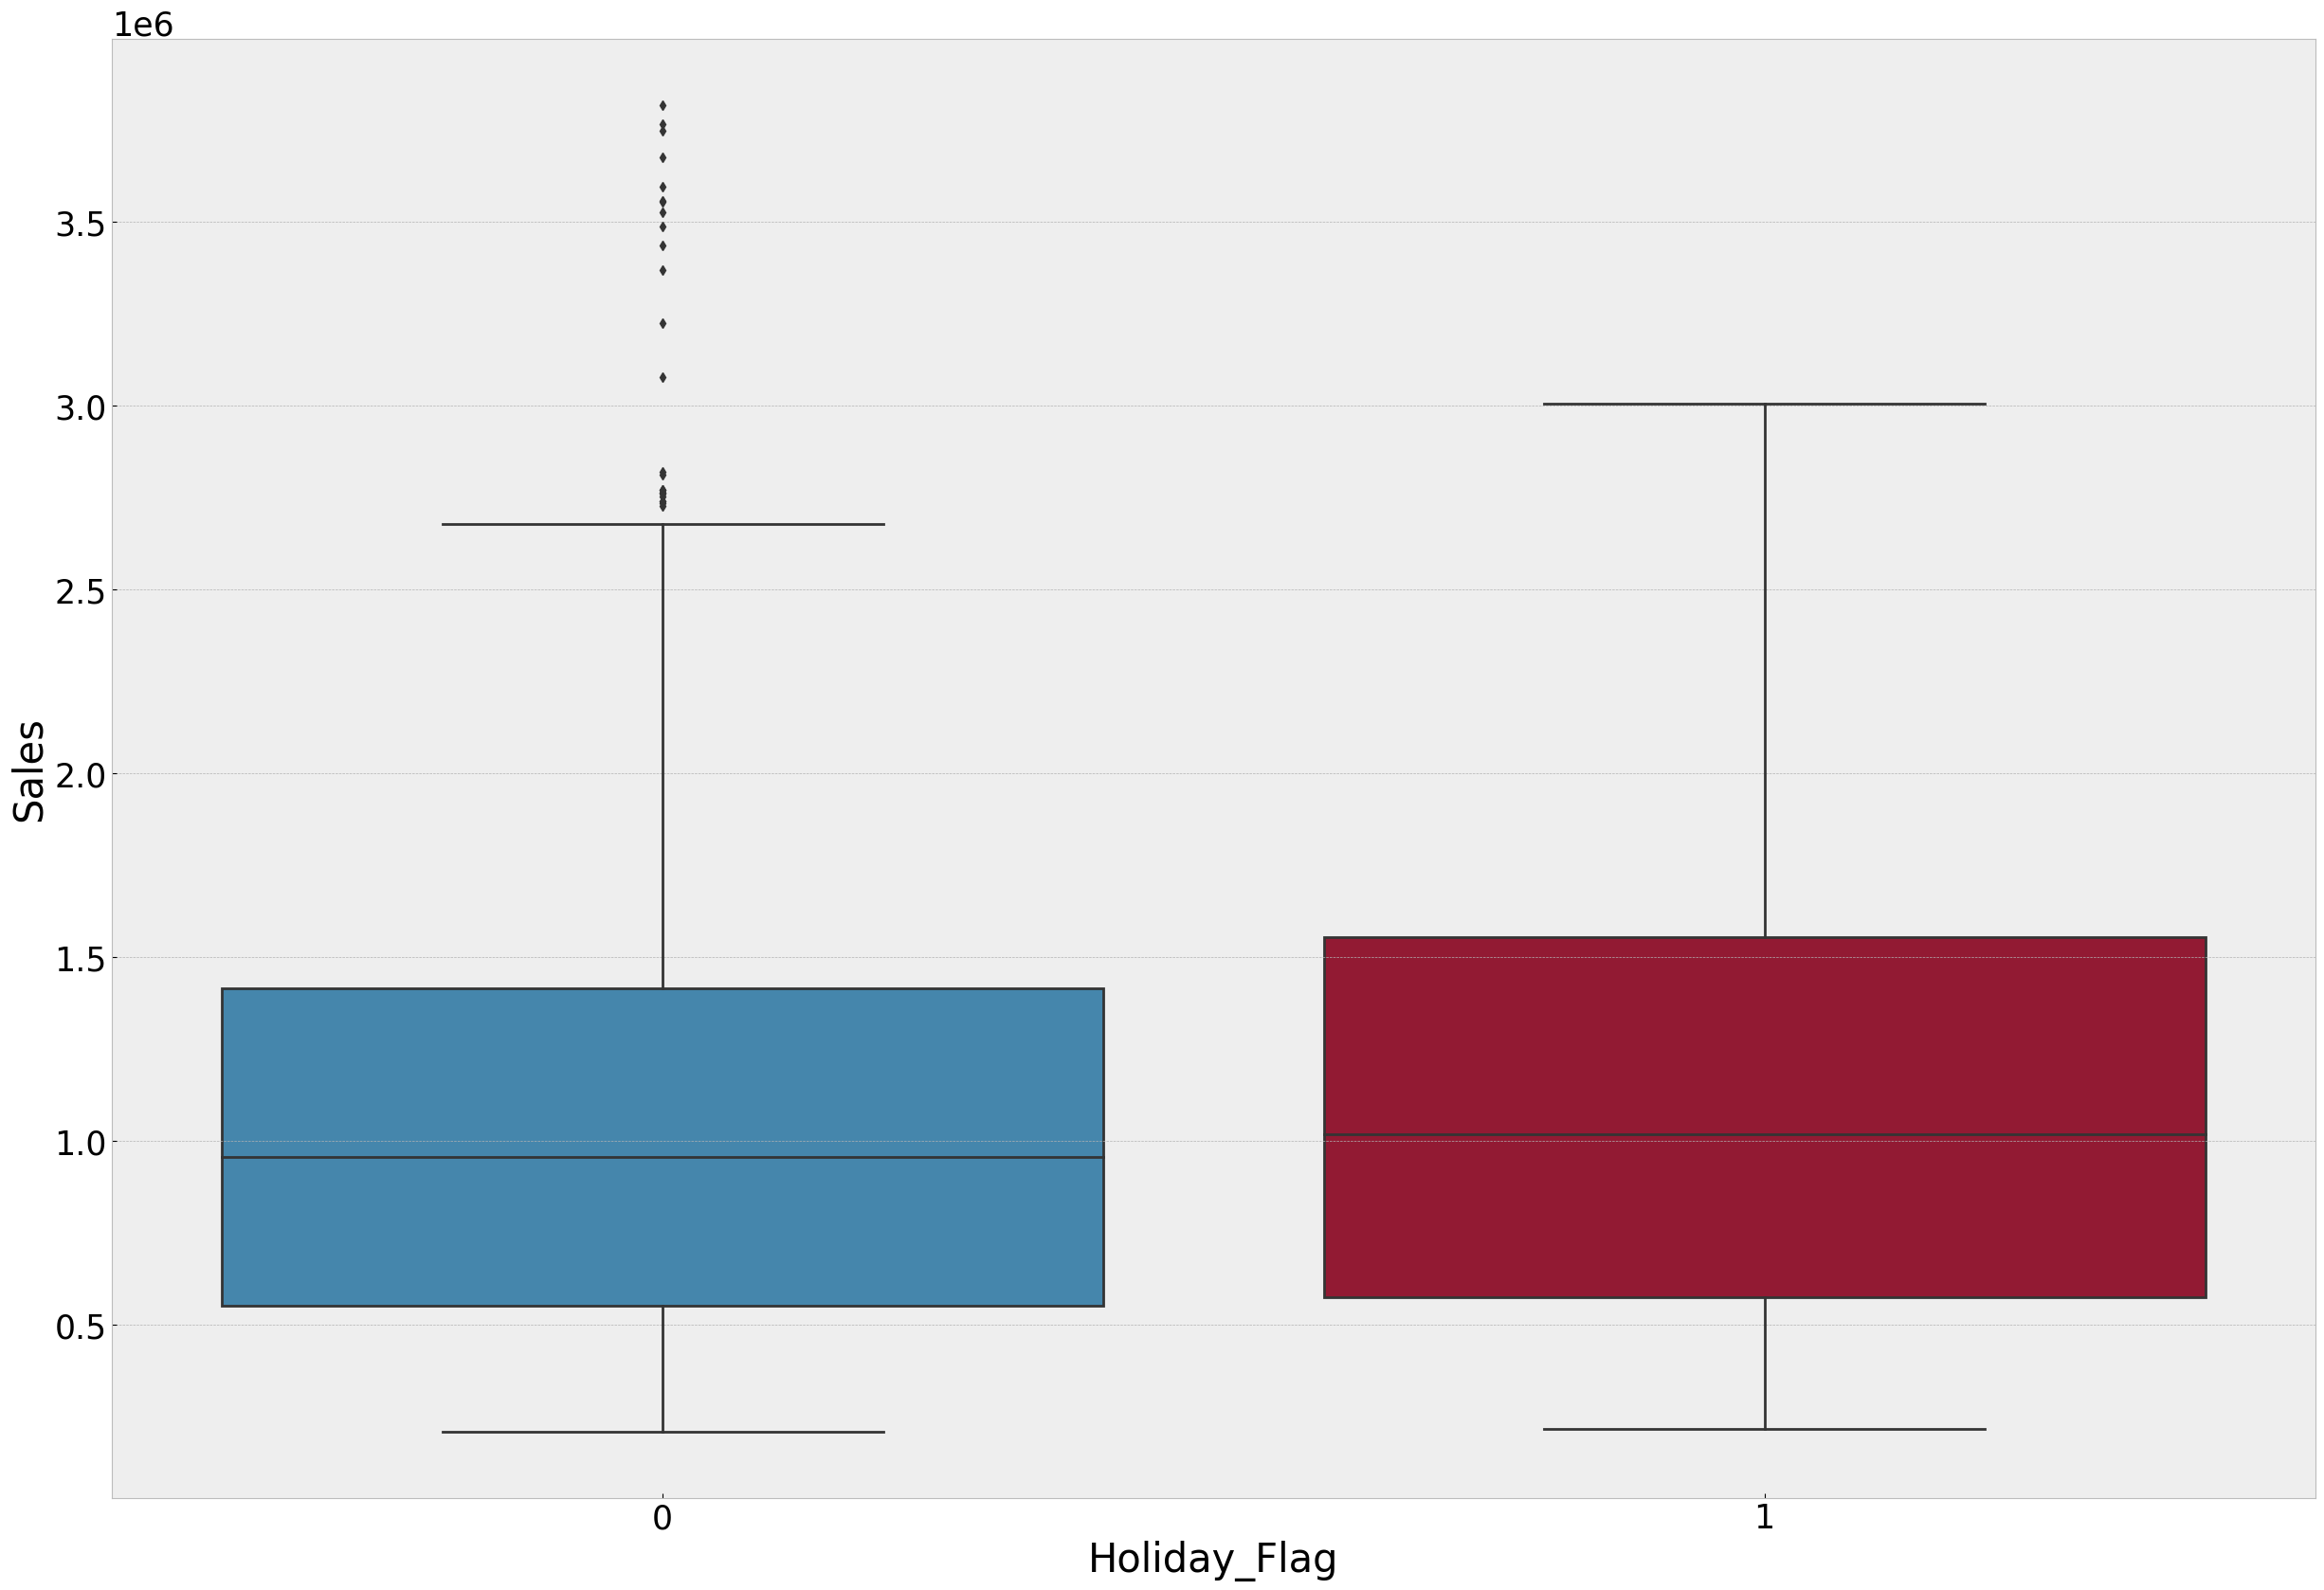

In [148]:
aux1 = df[(df['Sales'] > 0)]
sns.boxplot(x='Holiday_Flag', y='Sales', data=aux1 )

<Axes: xlabel='Date', ylabel='Sales'>

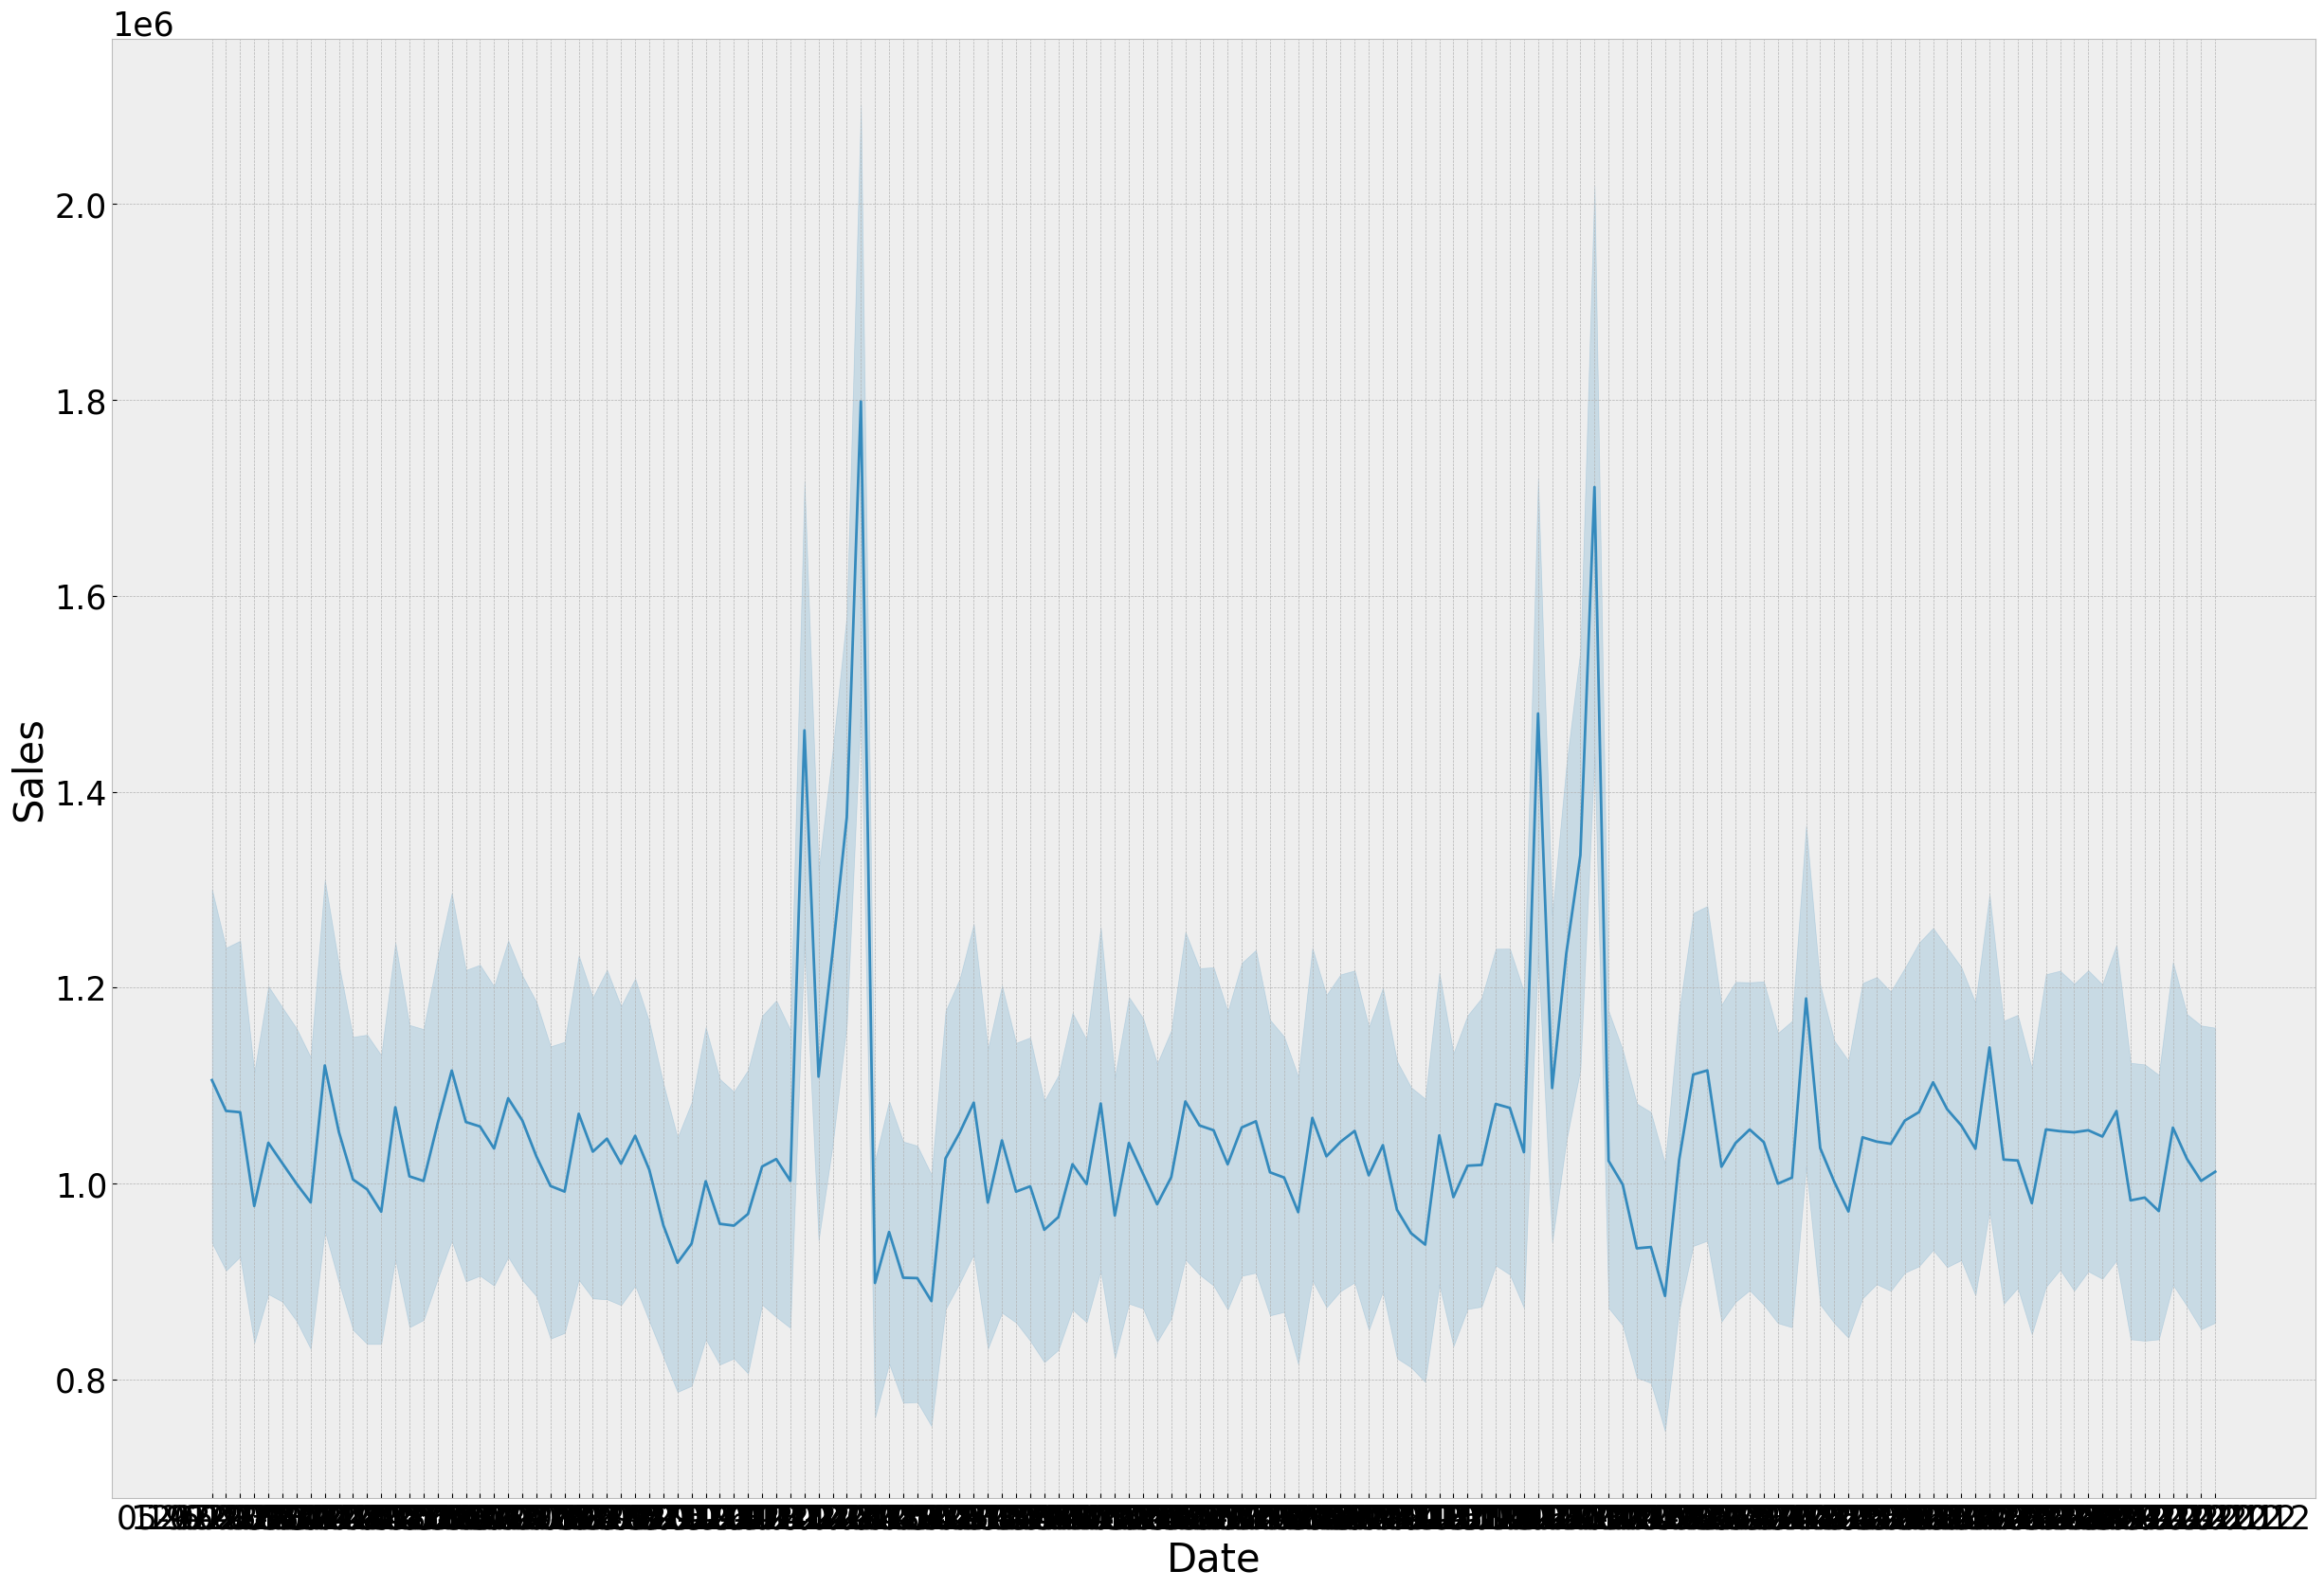

In [149]:
sns.lineplot(data=aux1, x='Date', y='Sales')


In [150]:
df2['Date'] = pd.to_datetime(df2['Date'], format = '%d-%m-%Y')

In [151]:
#Extrair informações de Datas
#Ano
df2['Year'] = df2['Date'].dt.year

#Mês
df2['Month'] = df2['Date'].dt.month

#Semana
#df2['Week'] = df2['Date'].dt.weekofyear

#Dia
df2['Day'] = df2['Date'].dt.day

In [152]:
num_attributes = df2[['Sales','Temperature','Fuel_Price','CPI','Unemployment']]
cat_attributes = df2[['Store','Date','Holiday_Flag','Year','Month','Day']]


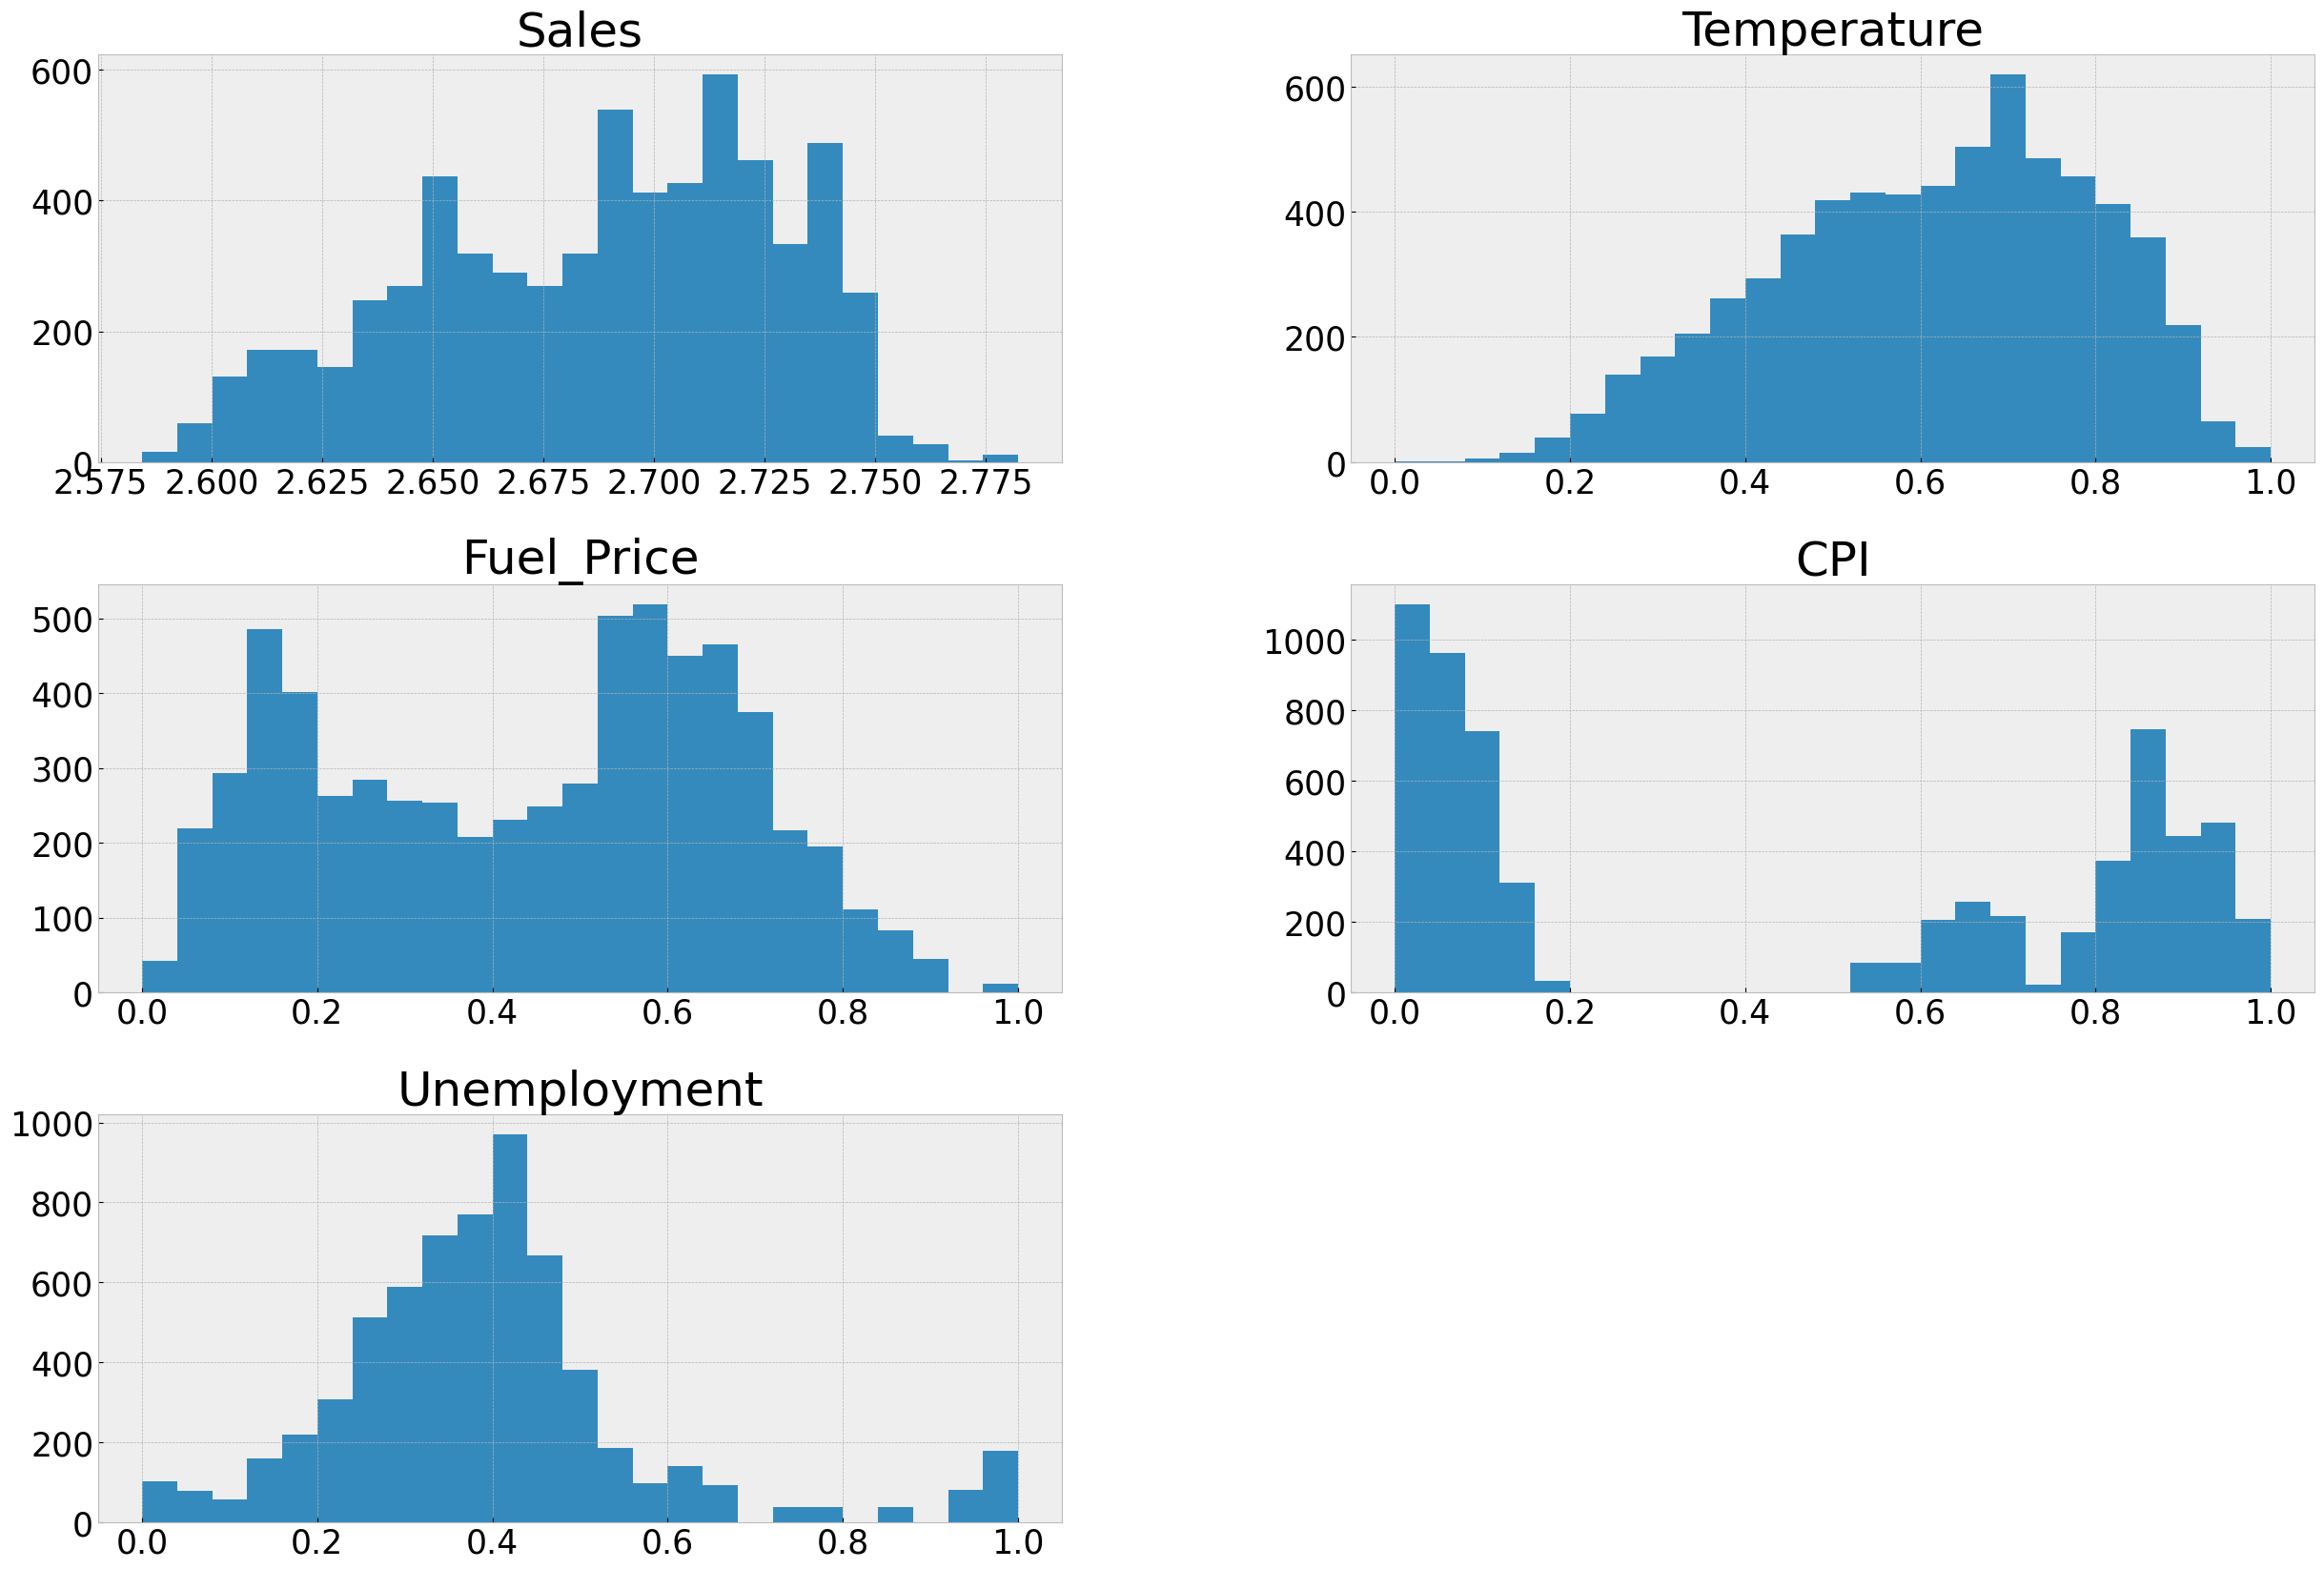

In [153]:
num_attributes.hist(bins=25);

In [154]:
#Lojas vendem mais em Feriados do que dias normais

<Axes: xlabel='Store', ylabel='CPI'>

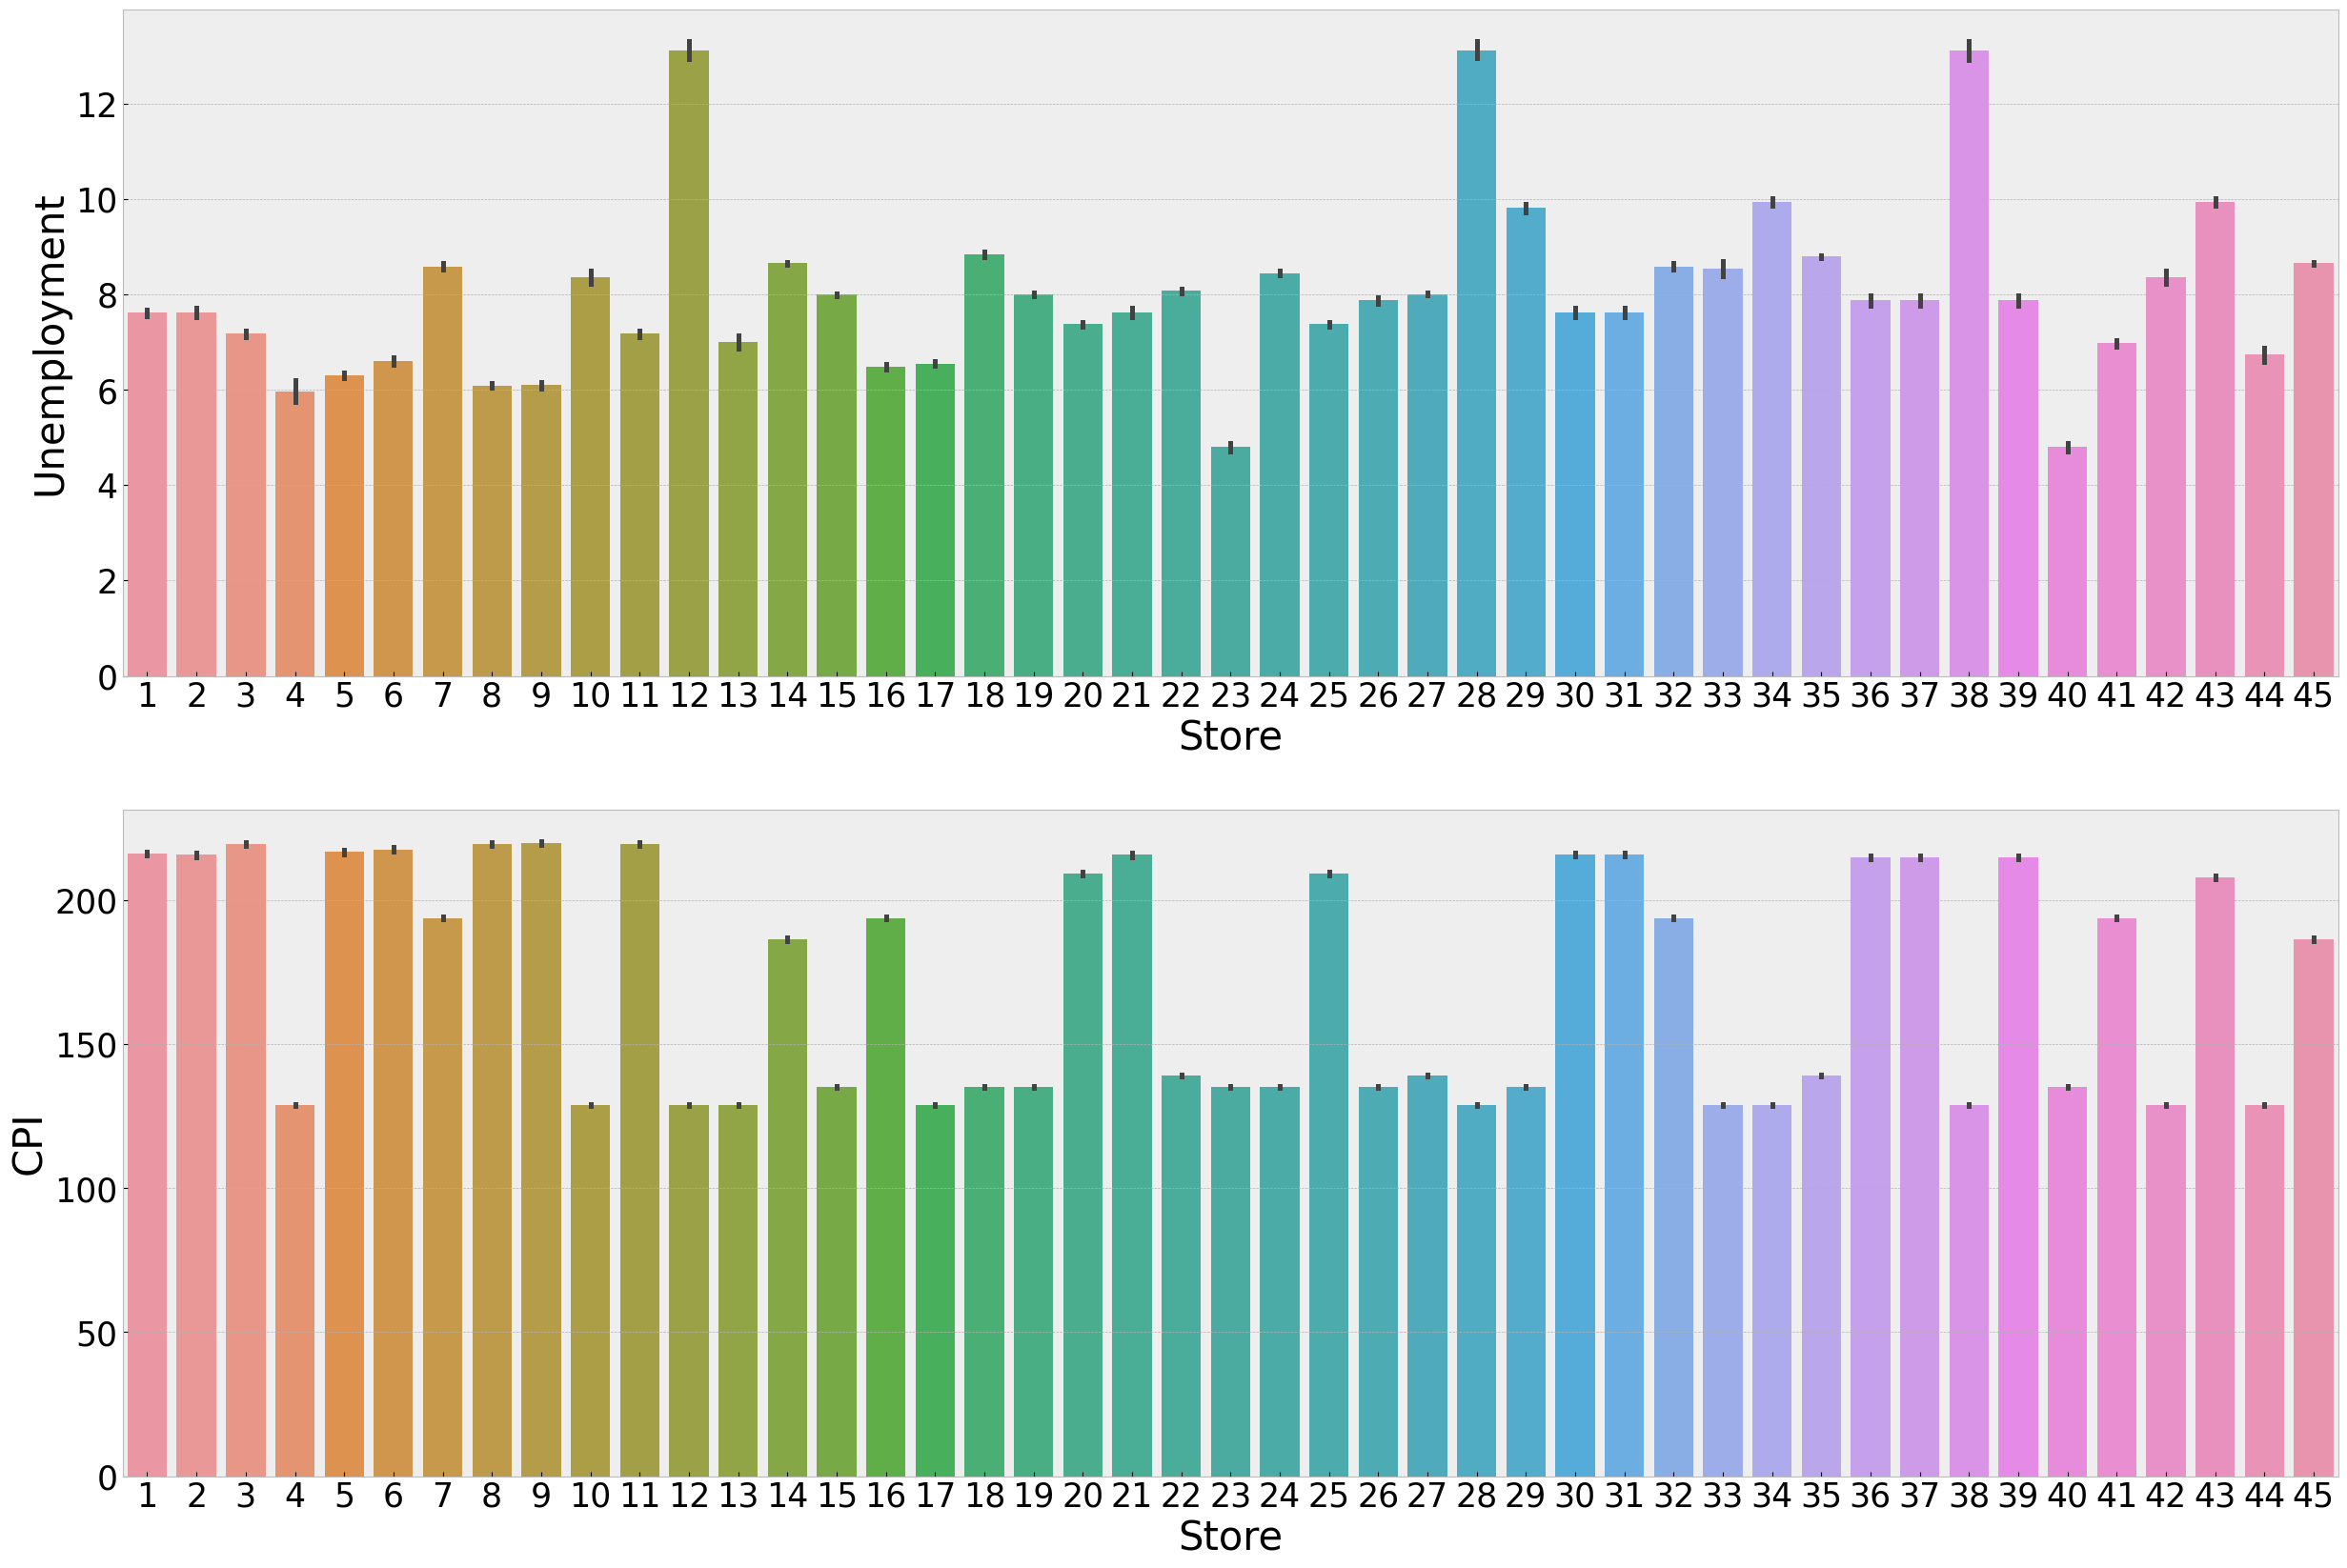

In [155]:
plt.subplot(2,1,1)
#df2[df2['Store'] == 11]
sns.barplot(x='Store', y='Unemployment', data= df)

plt.subplot(2,1,2)
#df2[df2['Store'] == 11]
sns.barplot(x='Store', y='CPI', data= df)

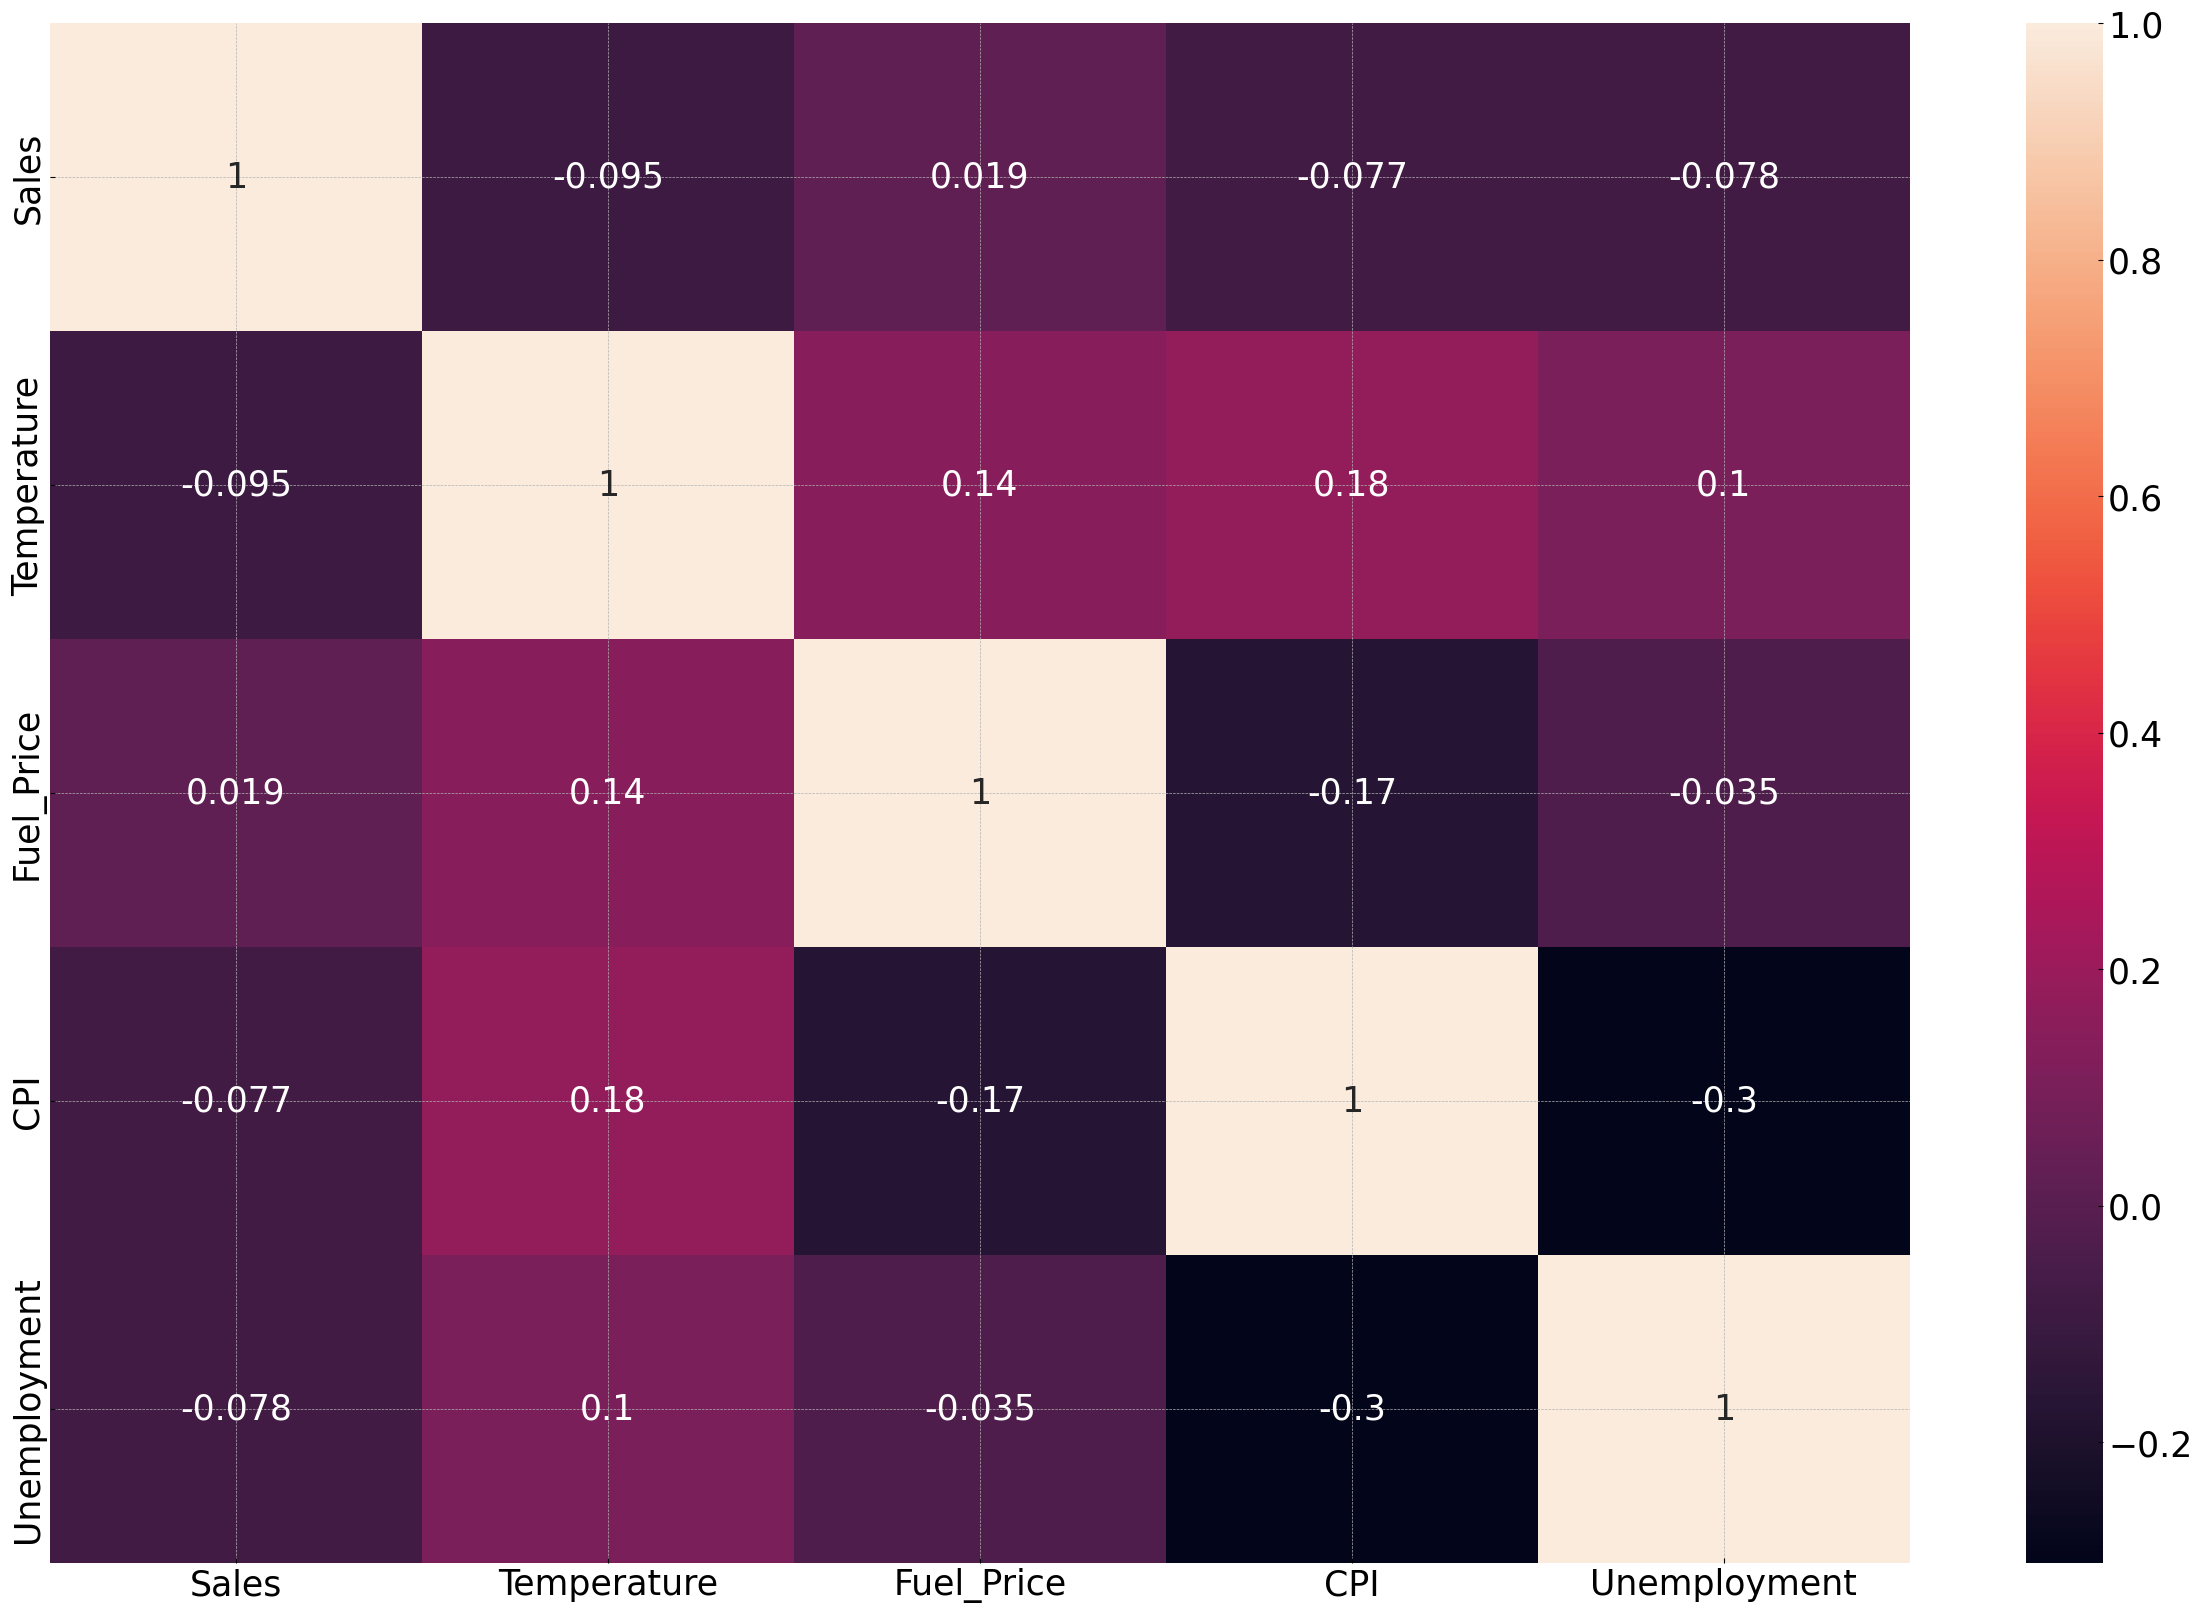

In [156]:
corr = num_attributes.corr(method='pearson')
sns.heatmap(corr, annot= True);

## 4.0 Pre processing

### 4.1 Scalling

In [157]:
mms = MinMaxScaler()


In [158]:
df2['Temperature'] = mms.fit_transform(df2[['Temperature']].values)
df2['Fuel_Price'] = mms.fit_transform(df2[['Fuel_Price']].values)
df2['CPI'] = mms.fit_transform(df2[['CPI']].values)
df2['Unemployment'] = mms.fit_transform(df2[['Unemployment']].values)


In [159]:
df2['Sales 2'] = np.log1p(df2['Sales'])

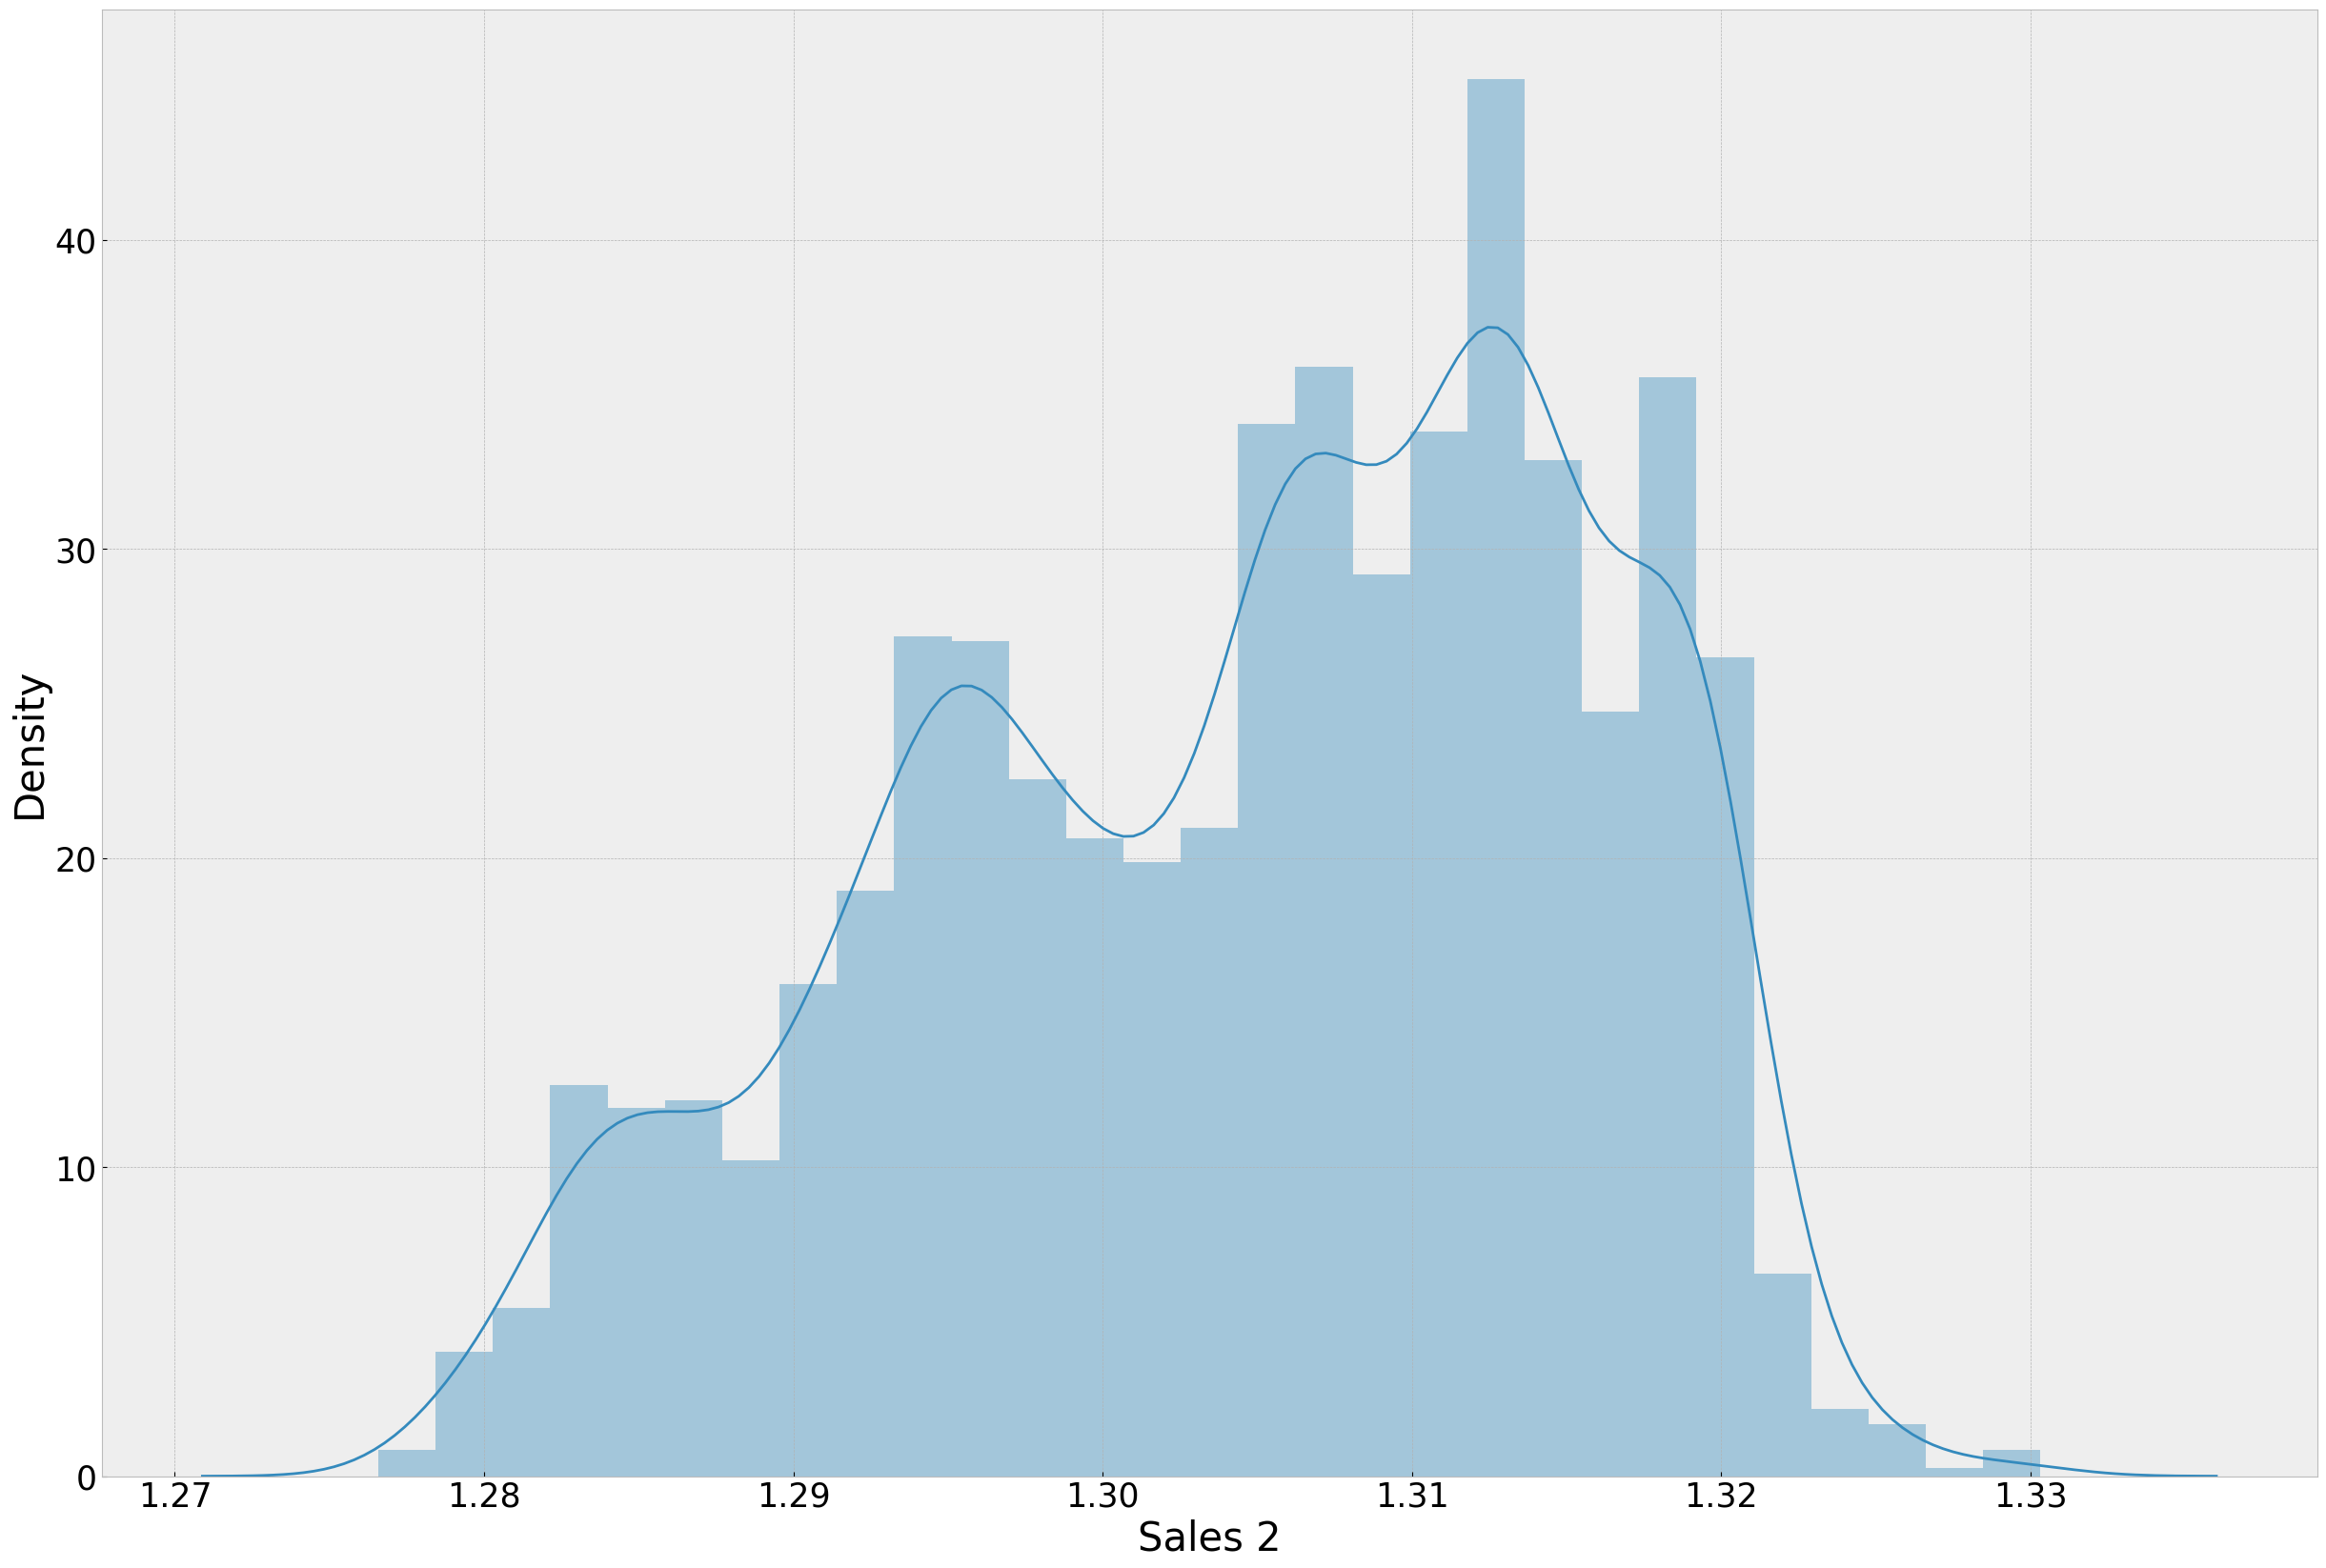

In [160]:
sns.distplot(df2['Sales 2']);

In [161]:
df = df2


In [162]:
df2['Sales'] = np.log1p(df2['Sales'])
df2.drop(columns='Sales 2', inplace =True)
df2

,Store,Date,Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day
0,1,2010-02-05,1.316051,0,0.434149,0.050100,0.840500,0.405118,2010,2,5
1,1,2010-02-12,1.316032,1,0.396967,0.038076,0.841941,0.405118,2010,2,12
2,1,2010-02-19,1.315709,0,0.410861,0.021042,0.842405,0.405118,2010,2,19
3,1,2010-02-26,1.313344,0,0.476419,0.044589,0.842707,0.405118,2010,2,26
4,1,2010-03-05,1.315075,0,0.475147,0.076653,0.843008,0.405118,2010,3,5
...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,1.300898,0,0.654990,0.764028,0.651876,0.460514,2012,9,28
6431,45,2012-10-05,1.301425,0,0.655088,0.758016,0.653427,0.458884,2012,10,5
6432,45,2012-10-12,1.301451,0,0.553131,0.765531,0.654977,0.458884,2012,10,12
6433,45,2012-10-19,1.301028,0,0.572701,0.750000,0.655013,0.458884,2012,10,19


## 5.0 Feature Selection 

In [163]:
# first lets split our datasets into Train and Test
MinDate = df2['Date'][0]
MaxDate = df2['Date'][6434]

#df2['Date'].sort_values(ascending=False)[6434]
#df2[['Sales']] = np.expm1(df2[['Sales']])

split = MaxDate - MinDate
splitDate = split*0.75+MinDate

xtrain = df2[df2['Date']<splitDate]
ytrain = xtrain['Sales']

xtest = df2[df2['Date']>=splitDate]
ytest = xtest['Sales']

xtrain_n = xtrain.drop(columns=['Date','Sales'])

datas = df2[df2['Date']>=splitDate]


<Axes: xlabel='Date', ylabel='Sales'>

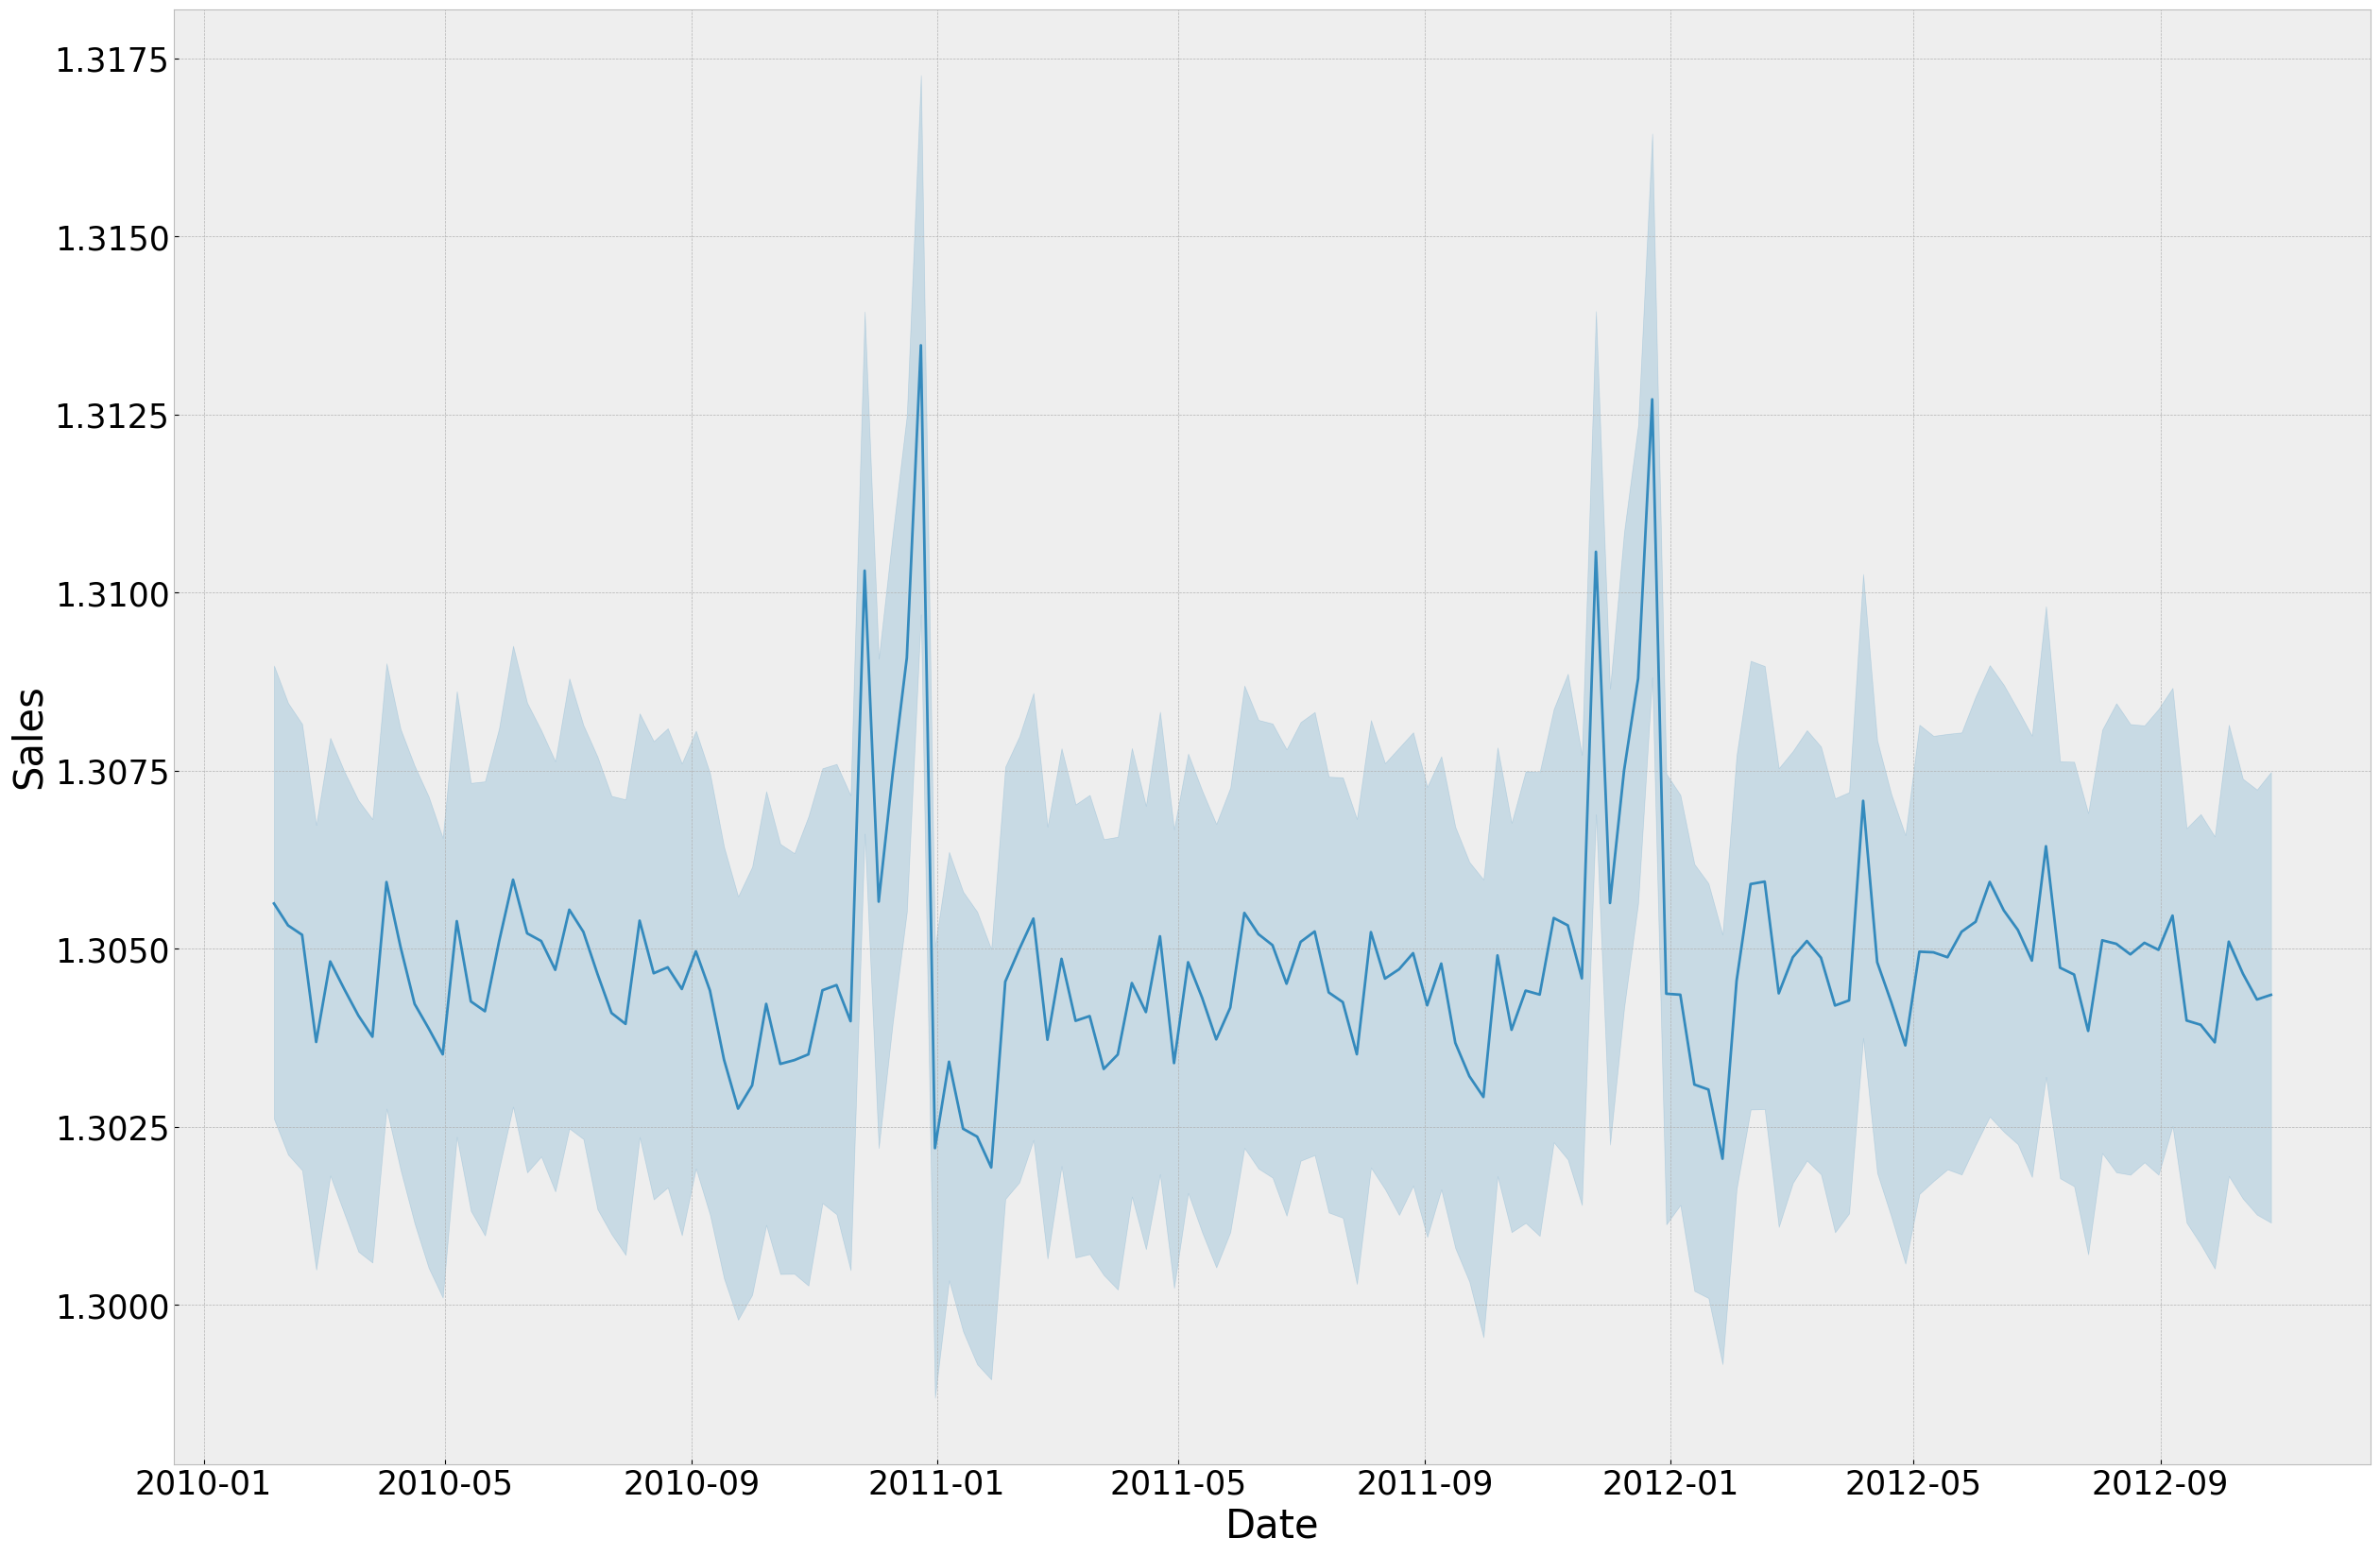

In [164]:
sns.lineplot(data=df2, x='Date',y='Sales')

In [165]:
df2['Sales 2'] = np.expm1(df2['Sales'])

In [166]:

rf = RandomForestRegressor(n_jobs=-1)

xtrain_n = xtrain_n.values
ytrain = ytrain.values.ravel()


In [ ]:
#boruta = BorutaPy(rf, n_estimators='auto',verbose=2,random_state=42).fit(xtrain_n, ytrain)

In [ ]:
#boruta.support_.tolist()
xtrain_boruta = xtrain.drop(columns=['Date','Sales'])


In [ ]:
#xtrain_boruta.columns[boruta.support_]

In [ ]:
#Segundo o Boruta, utilizando o metodo de Random Forest, identificamos que as features que fazem sentido para o modelo são:
cols_boruta = ['Store','Temperature','Fuel_Price','CPI','Unemployment']

In [ ]:
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat)/y))
    

def ml_error( model_name, y, yhat):
    mae = mean_absolute_error(y, yhat) 
    mape = mean_absolute_percentage_error( y, yhat)
    rmse = np.sqrt(mean_squared_error( y, yhat)) 
    
    return pd.DataFrame({'Model Name': model_name, 'MAE': mae, 'MAPE': mape, 'RMSE': rmse}, index=[0])

In [ ]:
xtrain = xtrain[cols_boruta]
xtest=xtest[cols_boruta]

## 6.0 Random Forest Regressor

In [ ]:
# Model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42).fit(xtrain, ytrain)

# Prediction
yhat_rf = rf.predict(xtest)

# Performance
rf_result = ml_error('Random Forest Regressor', np.expm1(ytest), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,0.008924,0.003324,0.015637


In [176]:
xtest.insert(5, "Predictions", yhat_rf)
xtest['Date'] = datas['Date']
xtest['Sales'] = ytest
xtest


,Store,Temperature,Fuel_Price,CPI,Unemployment,Predictions,Date,Sales
107,1,0.580333,0.542585,0.934803,0.332471,1.316369,2012-02-24,1.314899
108,1,0.616634,0.580160,0.936890,0.332471,1.316440,2012-03-02,1.316520
109,1,0.595108,0.599699,0.938977,0.332471,1.316397,2012-03-09,1.316385
110,1,0.653620,0.632265,0.940486,0.332471,1.316207,2012-03-16,1.316407
111,1,0.665264,0.658818,0.941223,0.332471,1.315915,2012-03-23,1.314572
...,...,...,...,...,...,...,...,...
6430,45,0.654990,0.764028,0.651876,0.460514,1.303407,2012-09-28,1.300898
6431,45,0.655088,0.758016,0.653427,0.458884,1.303407,2012-10-05,1.301425
6432,45,0.553131,0.765531,0.654977,0.458884,1.303519,2012-10-12,1.301451
6433,45,0.572701,0.750000,0.655013,0.458884,1.303519,2012-10-19,1.301028


<Axes: xlabel='Date', ylabel='Sales'>

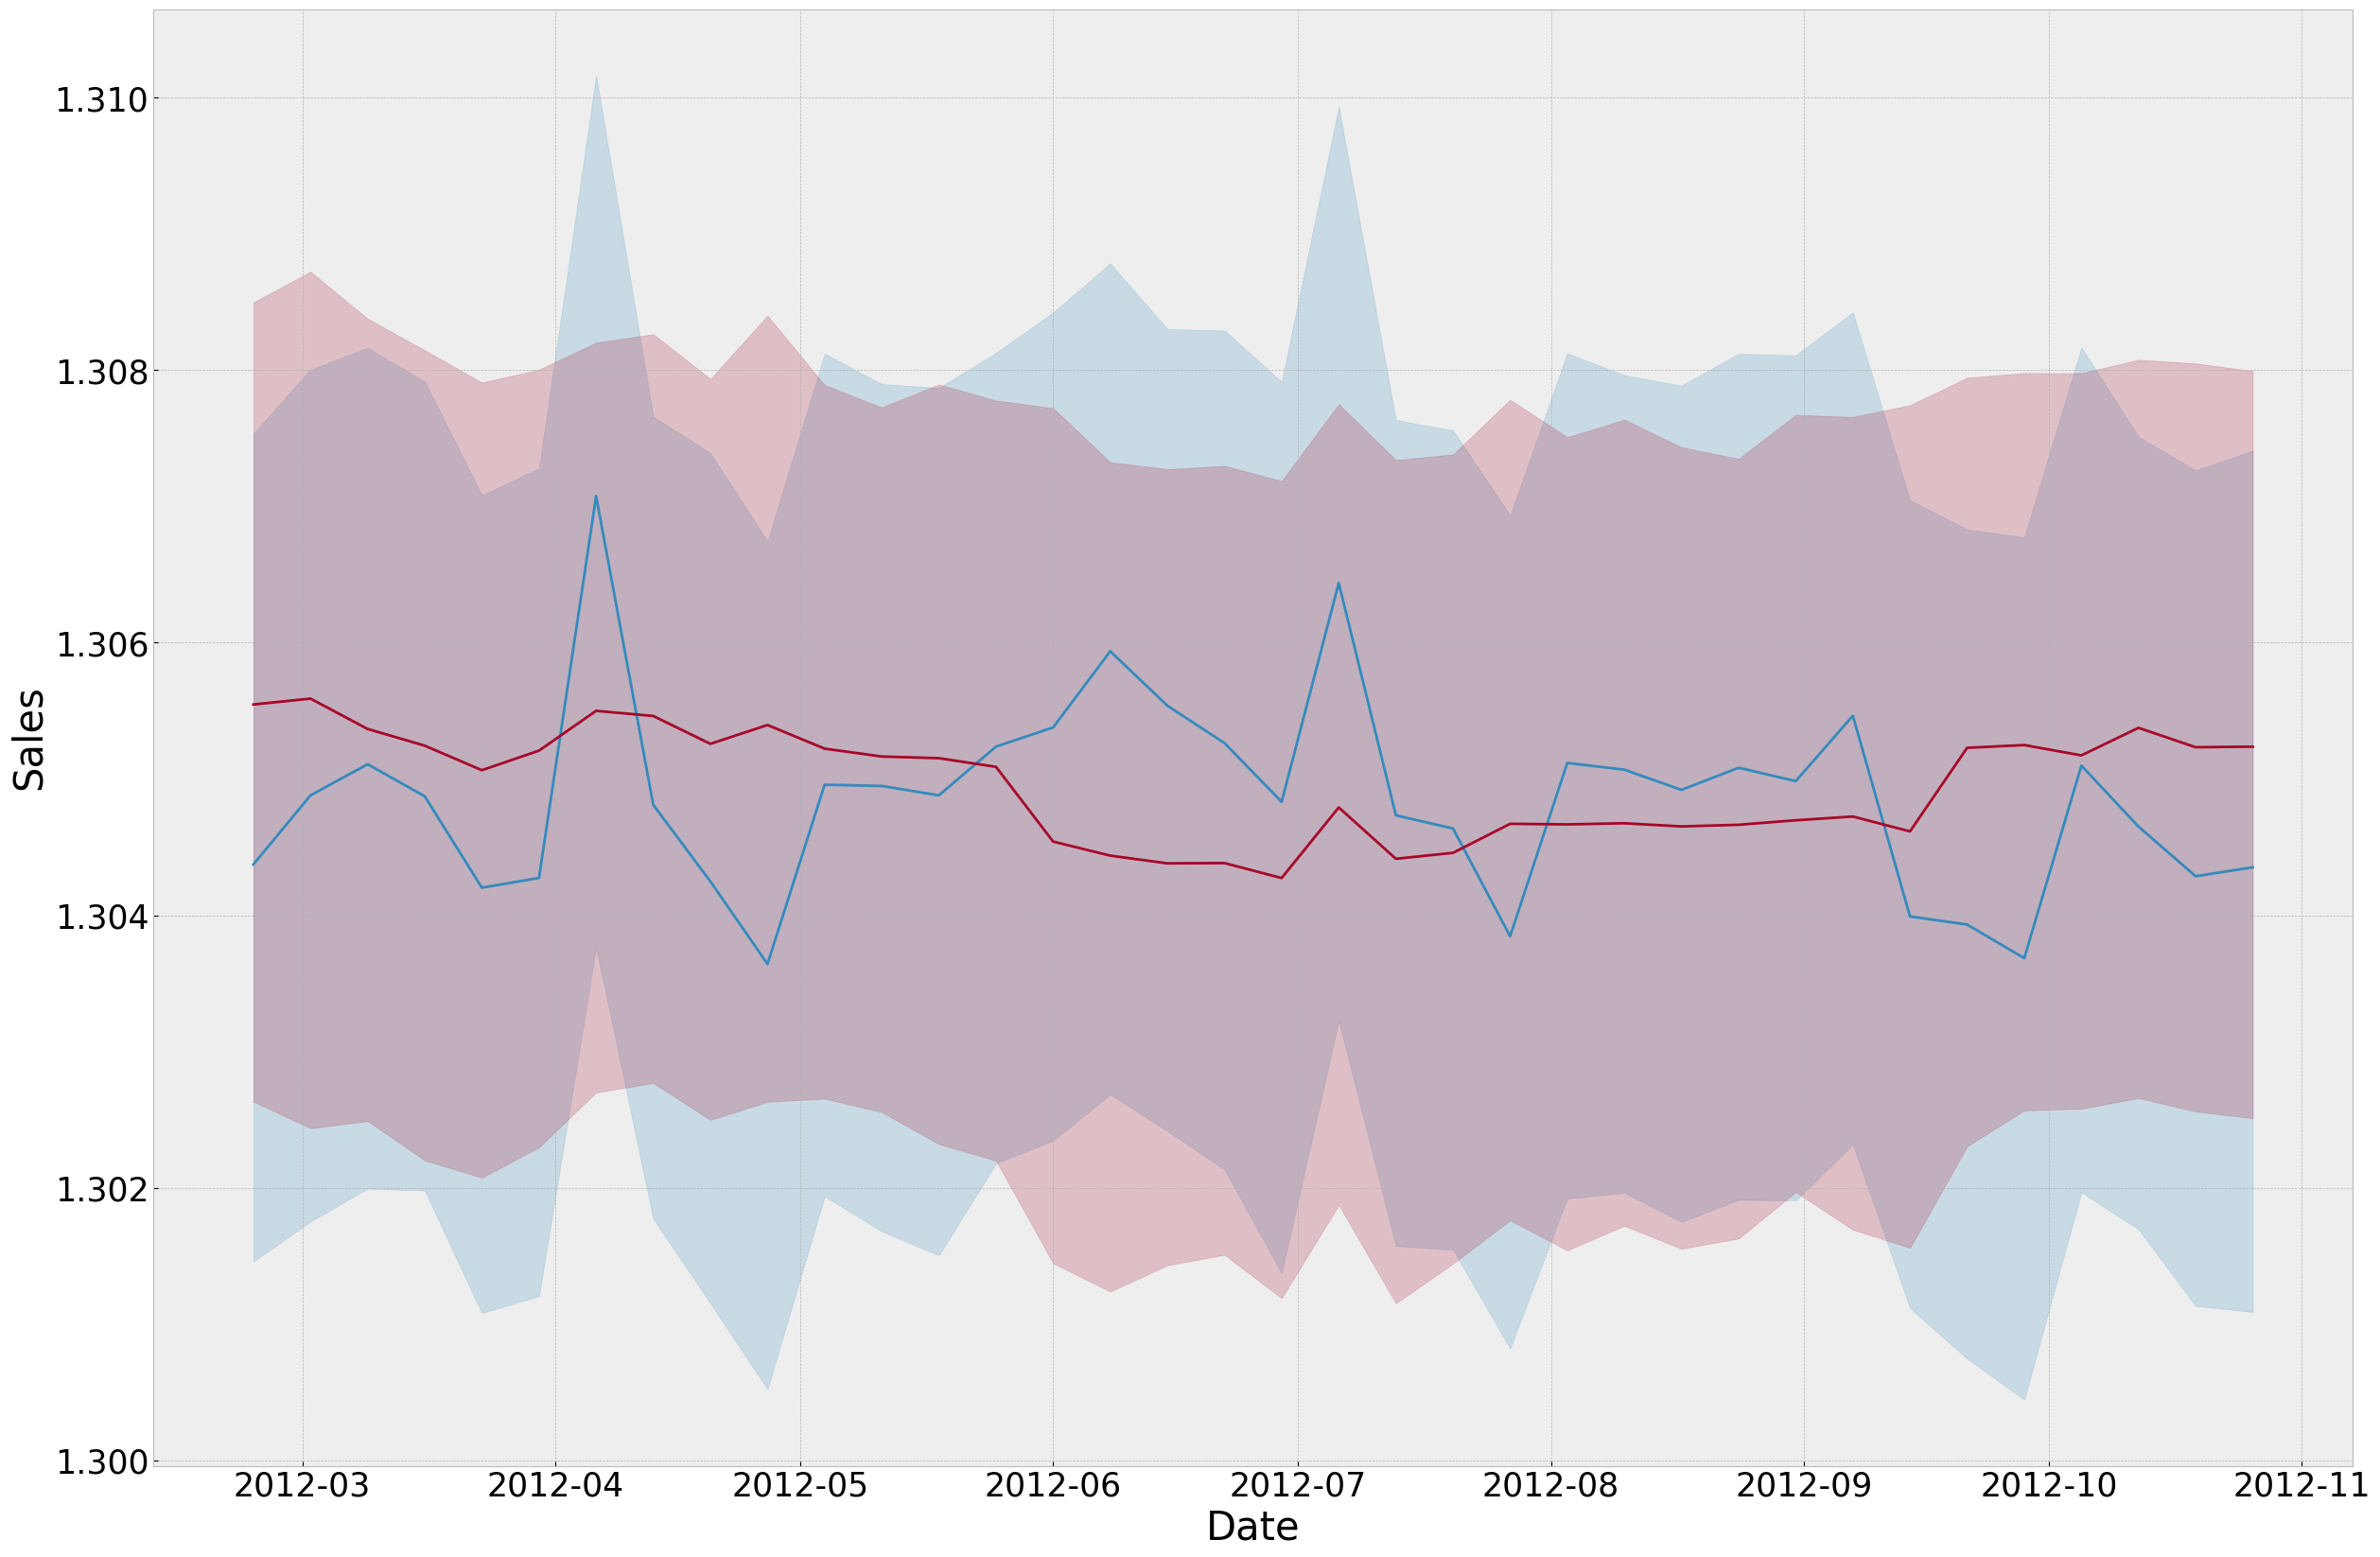

In [177]:
sns.lineplot(data=xtest, x='Date', y='Sales')
sns.lineplot(data=xtest, x='Date', y='Predictions')


## 7.0 XGBoost Model

In [178]:
xtrain = xtrain[cols_boruta]
xtest=xtest[cols_boruta]

In [179]:
yhat_xgb = xgb.XGBRegressor(n_estimators=1000, max_depth=10,eta=0.1,subsample=0.7,colsample_bytree=1)
y_tnn_xgb = xgb.XGBRegressor(n_estimators=975, max_depth=50,eta=00.05,subsample=0.2,colsample_bytree=0.9)

In [180]:
yhat_xgb.fit(xtrain,ytrain)
y_tnn_xgb.fit(xtrain,ytrain)

yhat_xgb.score(xtrain,ytrain)
y_tnn_xgb.score(xtrain,ytrain)



0.9974345035058334

In [181]:
ypred = yhat_xgb.predict(xtest)
ypred_tnn = y_tnn_xgb.predict(xtest)


In [182]:
xtest['Predictions_XGB'] = np.expm1(ypred)
xtest['Sales'] = np.expm1(ytest)

In [183]:
xtest

,Store,Temperature,Fuel_Price,CPI,Unemployment,Predictions_XGB,Sales
107,1,0.580333,0.542585,0.934803,0.332471,2.730417,2.724376
108,1,0.616634,0.580160,0.936890,0.332471,2.729144,2.730418
109,1,0.595108,0.599699,0.938977,0.332471,2.727968,2.729915
110,1,0.653620,0.632265,0.940486,0.332471,2.726407,2.729994
111,1,0.665264,0.658818,0.941223,0.332471,2.726935,2.723157
...,...,...,...,...,...,...,...
6430,45,0.654990,0.764028,0.651876,0.460514,2.680619,2.672594
6431,45,0.655088,0.758016,0.653427,0.458884,2.680349,2.674529
6432,45,0.553131,0.765531,0.654977,0.458884,2.679772,2.674624
6433,45,0.572701,0.750000,0.655013,0.458884,2.681251,2.673072


<Axes: xlabel='Sales', ylabel='Predictions_XGB'>

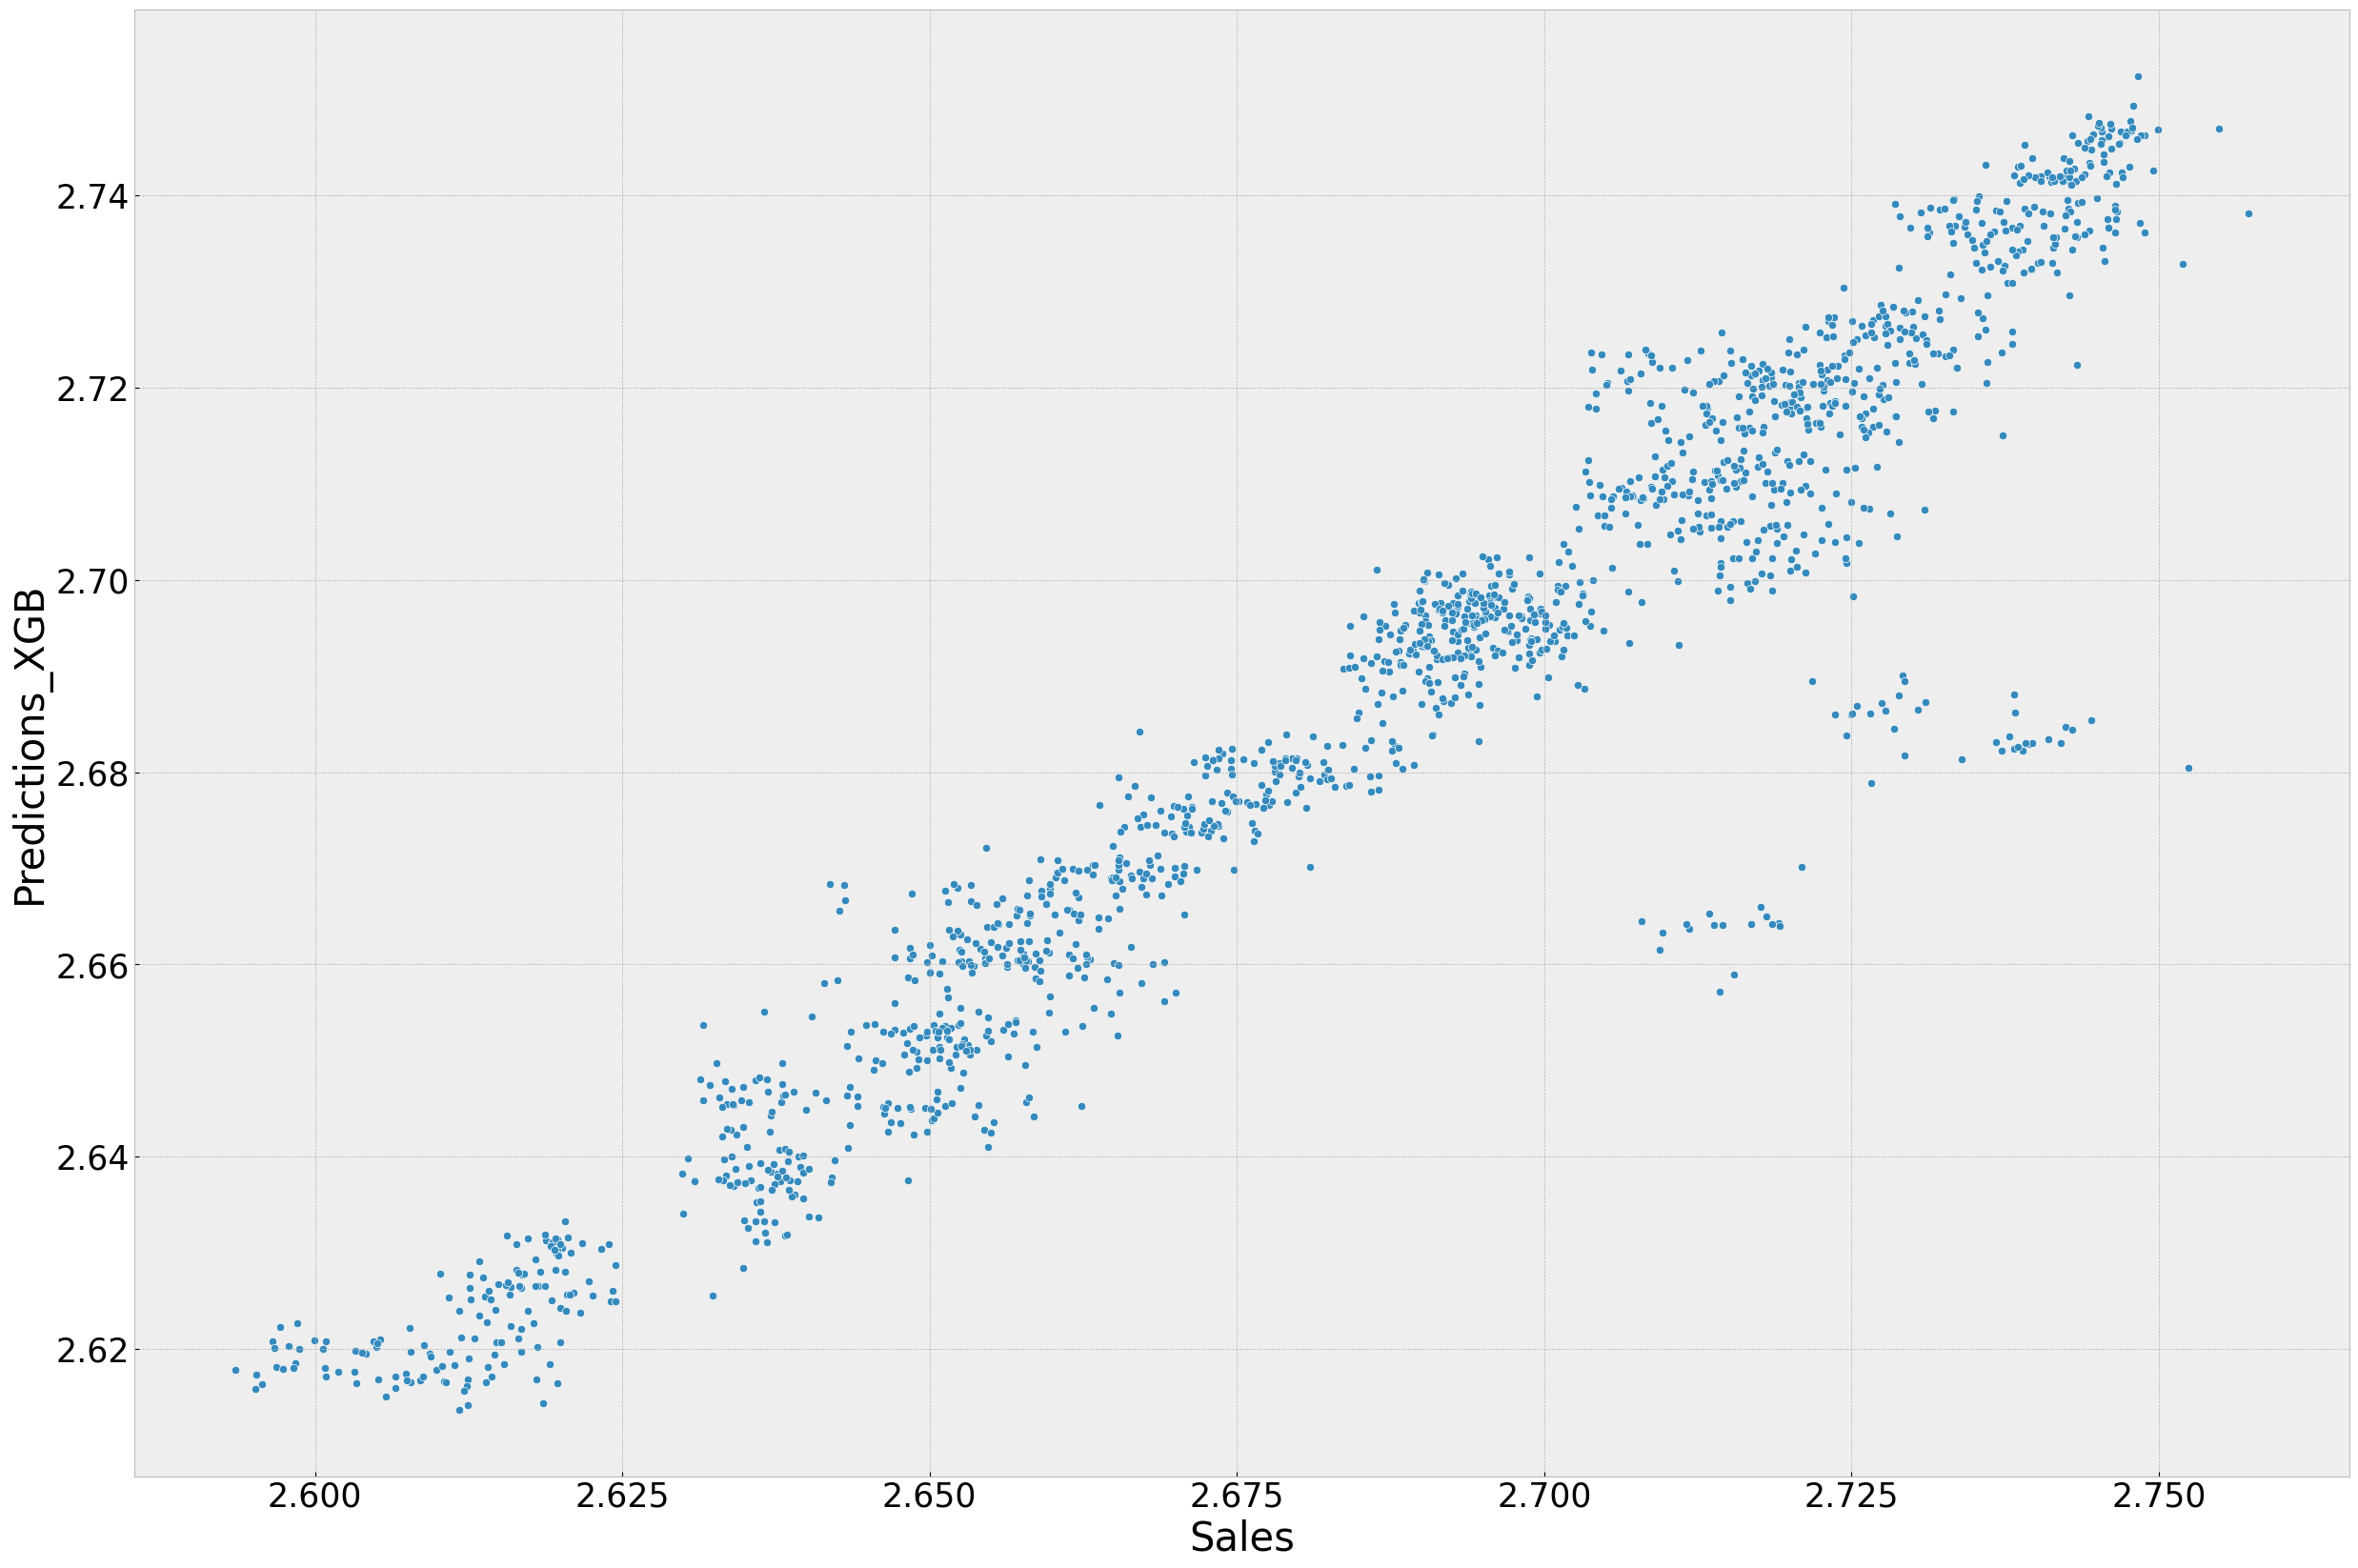

In [184]:
sns.scatterplot(data = xtest, x='Sales', y='Predictions_XGB')

In [185]:
xtest

,Store,Temperature,Fuel_Price,CPI,Unemployment,Predictions_XGB,Sales
107,1,0.580333,0.542585,0.934803,0.332471,2.730417,2.724376
108,1,0.616634,0.580160,0.936890,0.332471,2.729144,2.730418
109,1,0.595108,0.599699,0.938977,0.332471,2.727968,2.729915
110,1,0.653620,0.632265,0.940486,0.332471,2.726407,2.729994
111,1,0.665264,0.658818,0.941223,0.332471,2.726935,2.723157
...,...,...,...,...,...,...,...
6430,45,0.654990,0.764028,0.651876,0.460514,2.680619,2.672594
6431,45,0.655088,0.758016,0.653427,0.458884,2.680349,2.674529
6432,45,0.553131,0.765531,0.654977,0.458884,2.679772,2.674624
6433,45,0.572701,0.750000,0.655013,0.458884,2.681251,2.673072


<Axes: xlabel='Date', ylabel='Sales'>

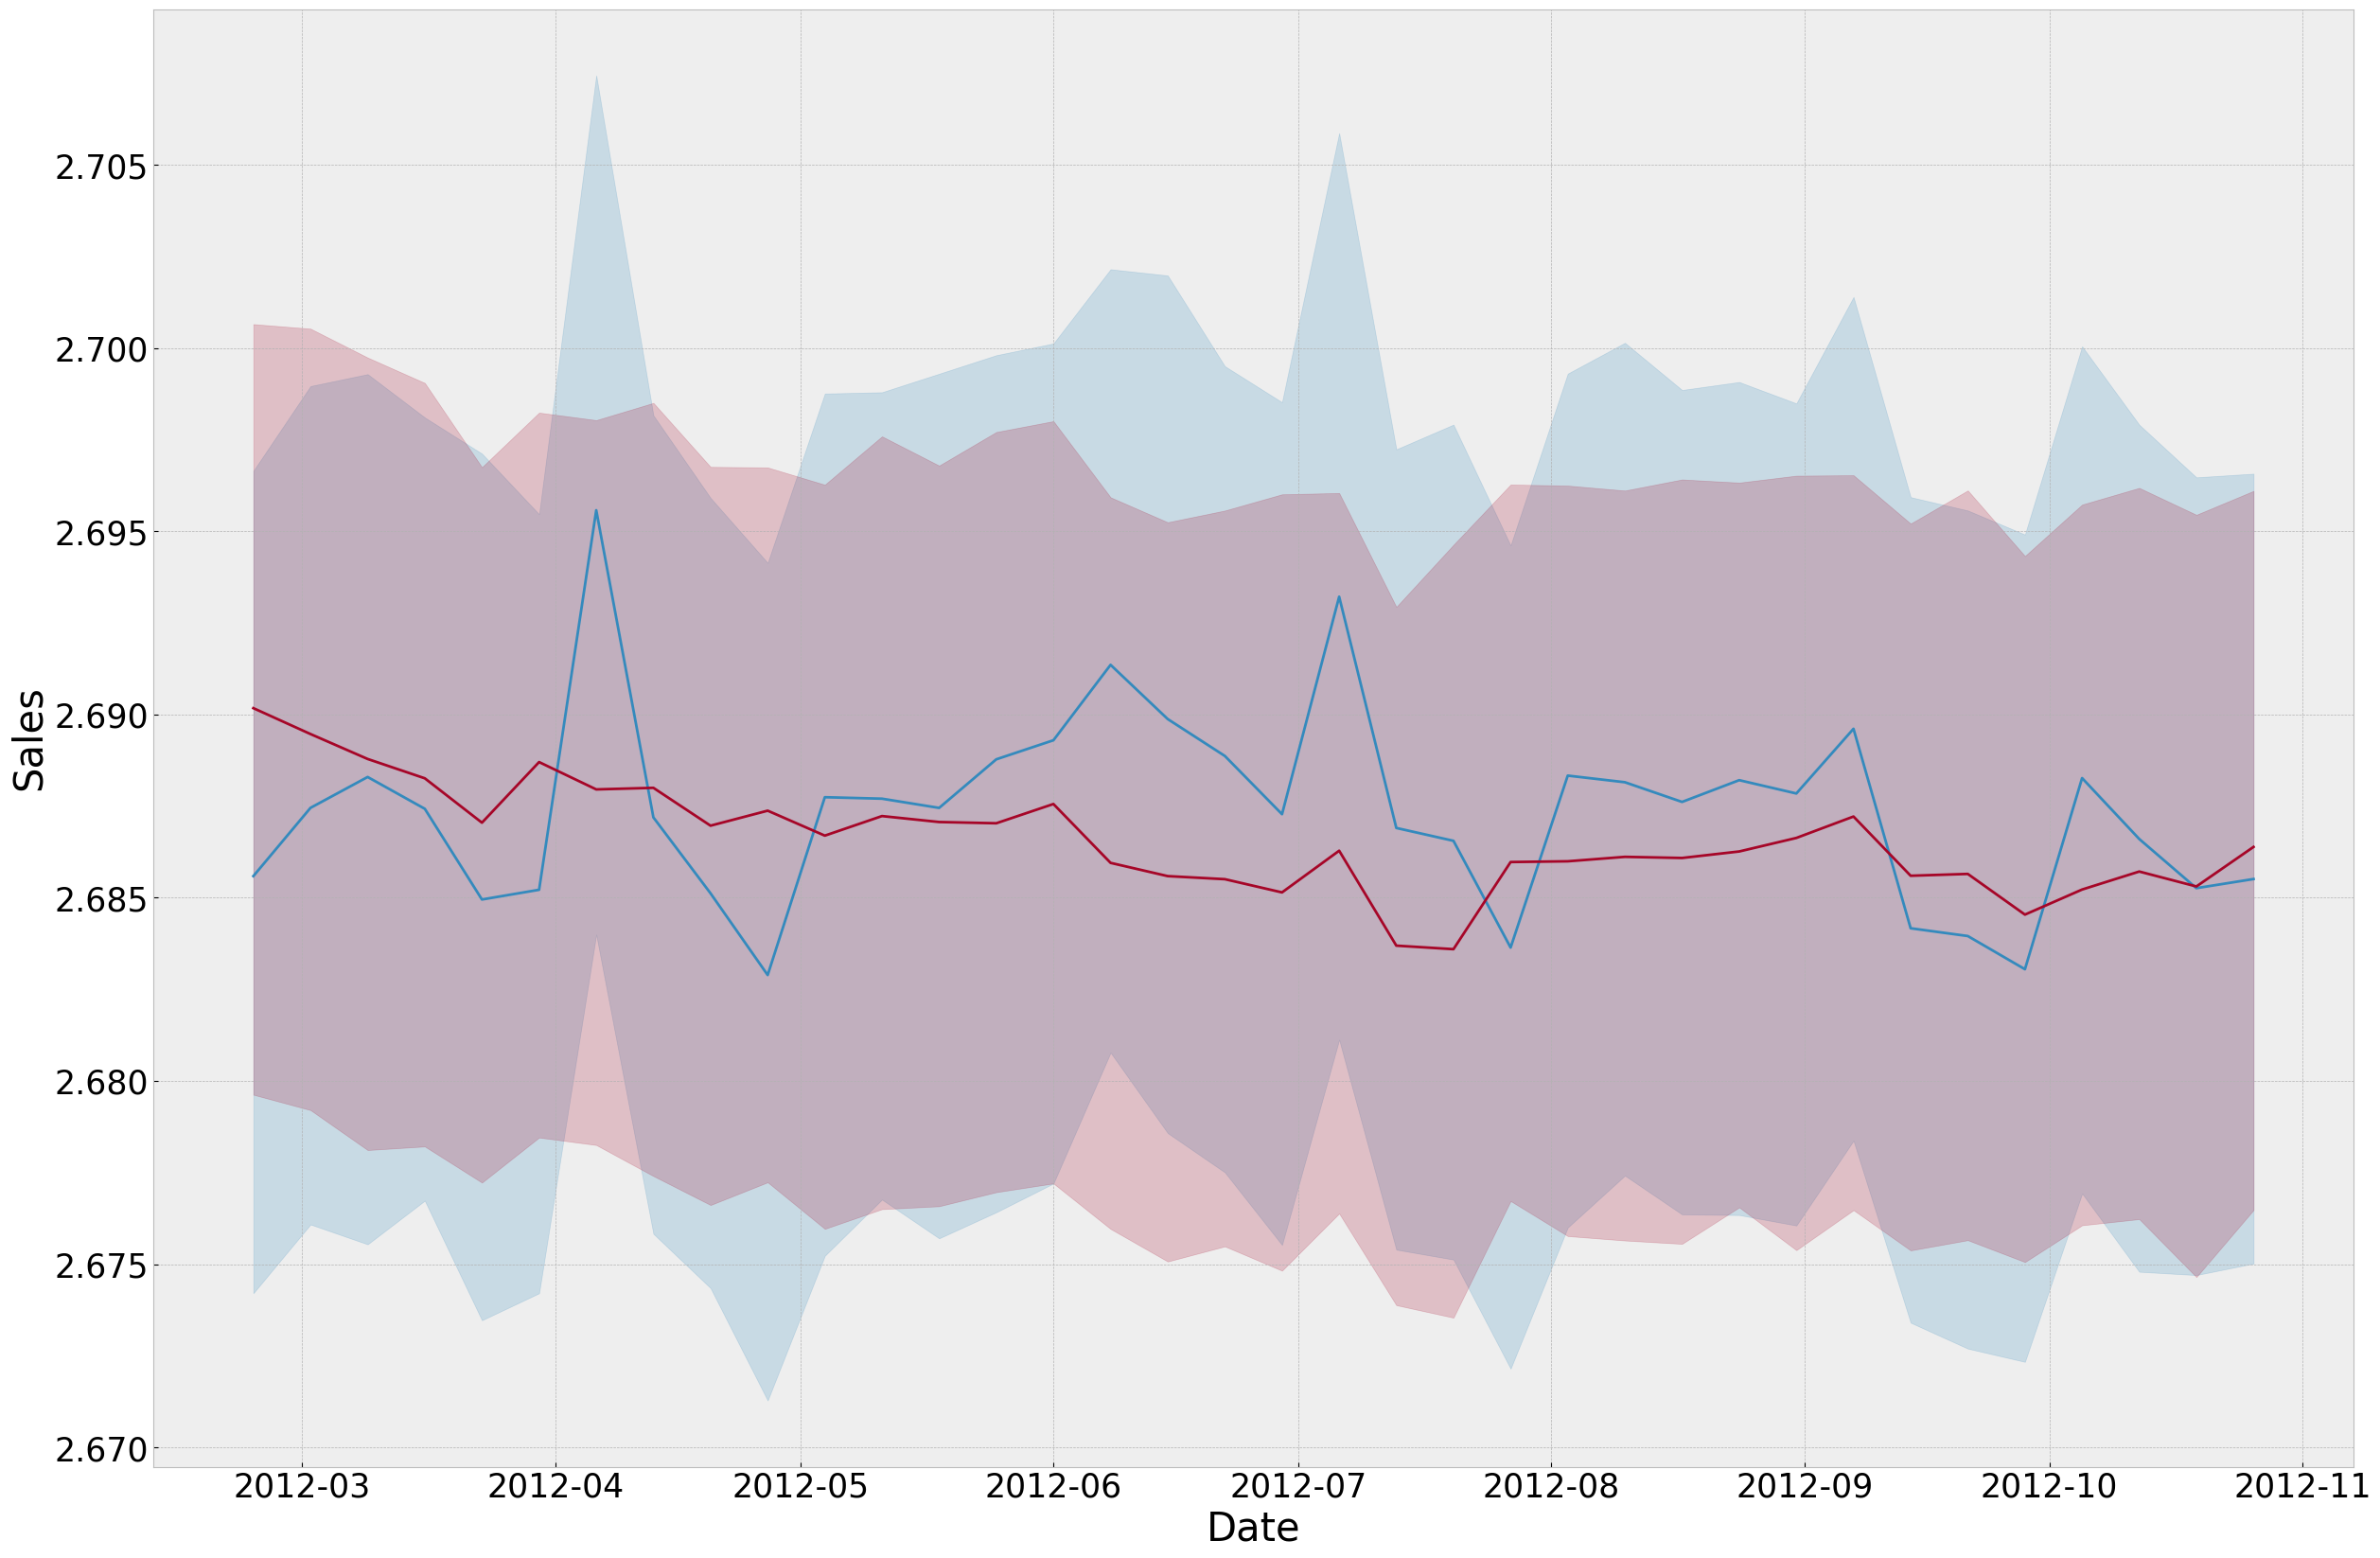

In [186]:
xtest['Date'] = datas['Date']
sns.lineplot(data=xtest, x='Date', y='Sales')
sns.lineplot(data=xtest, x='Date', y='Predictions_XGB')


In [187]:
ytest

107     1.314899
108     1.316520
109     1.316385
110     1.316407
111     1.314572
          ...   
6430    1.300898
6431    1.301425
6432    1.301451
6433    1.301028
6434    1.302098
Name: Sales, Length: 1620, dtype: float64

In [188]:
xgb_result = ml_error('XGBRegressor', np.expm1(ytest), np.expm1(ypred))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBRegressor,0.007321,0.002722,0.011778


In [189]:
# Models Compare
modelling_result = pd.concat([rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,XGBRegressor,0.007321,0.002722,0.011778
0,Random Forest Regressor,0.008924,0.003324,0.015637


## 8.0 Params Hyper Tunning

In [190]:
param={
    "n_estimators" : np.arange(800,1200,25),
    "max_depth" : np.arange(0,80,5),
    "eta" : np.arange(0,0.8,0.05),
    "subsample" : np.arange(0,0.8,0.05),
    "colsample_bytree" : np.arange(0.2,1,0.05)
}


In [191]:
model = xgb.XGBRegressor()
#random_search = RandomizedSearchCV(model, param_distributions=param, n_iter = 7, scoring = 'roc_auc',n_jobs = -1,cv=5,verbose=3)

In [192]:
#start_time = datetime.now()
#random_search.fit(xtrain, ytrain)
#endtime = datetime.now()

In [193]:
#endtime - start_time

In [194]:
#random_search.best_params_

## Error interpretation

In [195]:
xtest['% Diff'] = ((xtest['Sales'] - xtest['Predictions_XGB'])/xtest['Sales'])*100

<Axes: xlabel='Date', ylabel='% Diff'>

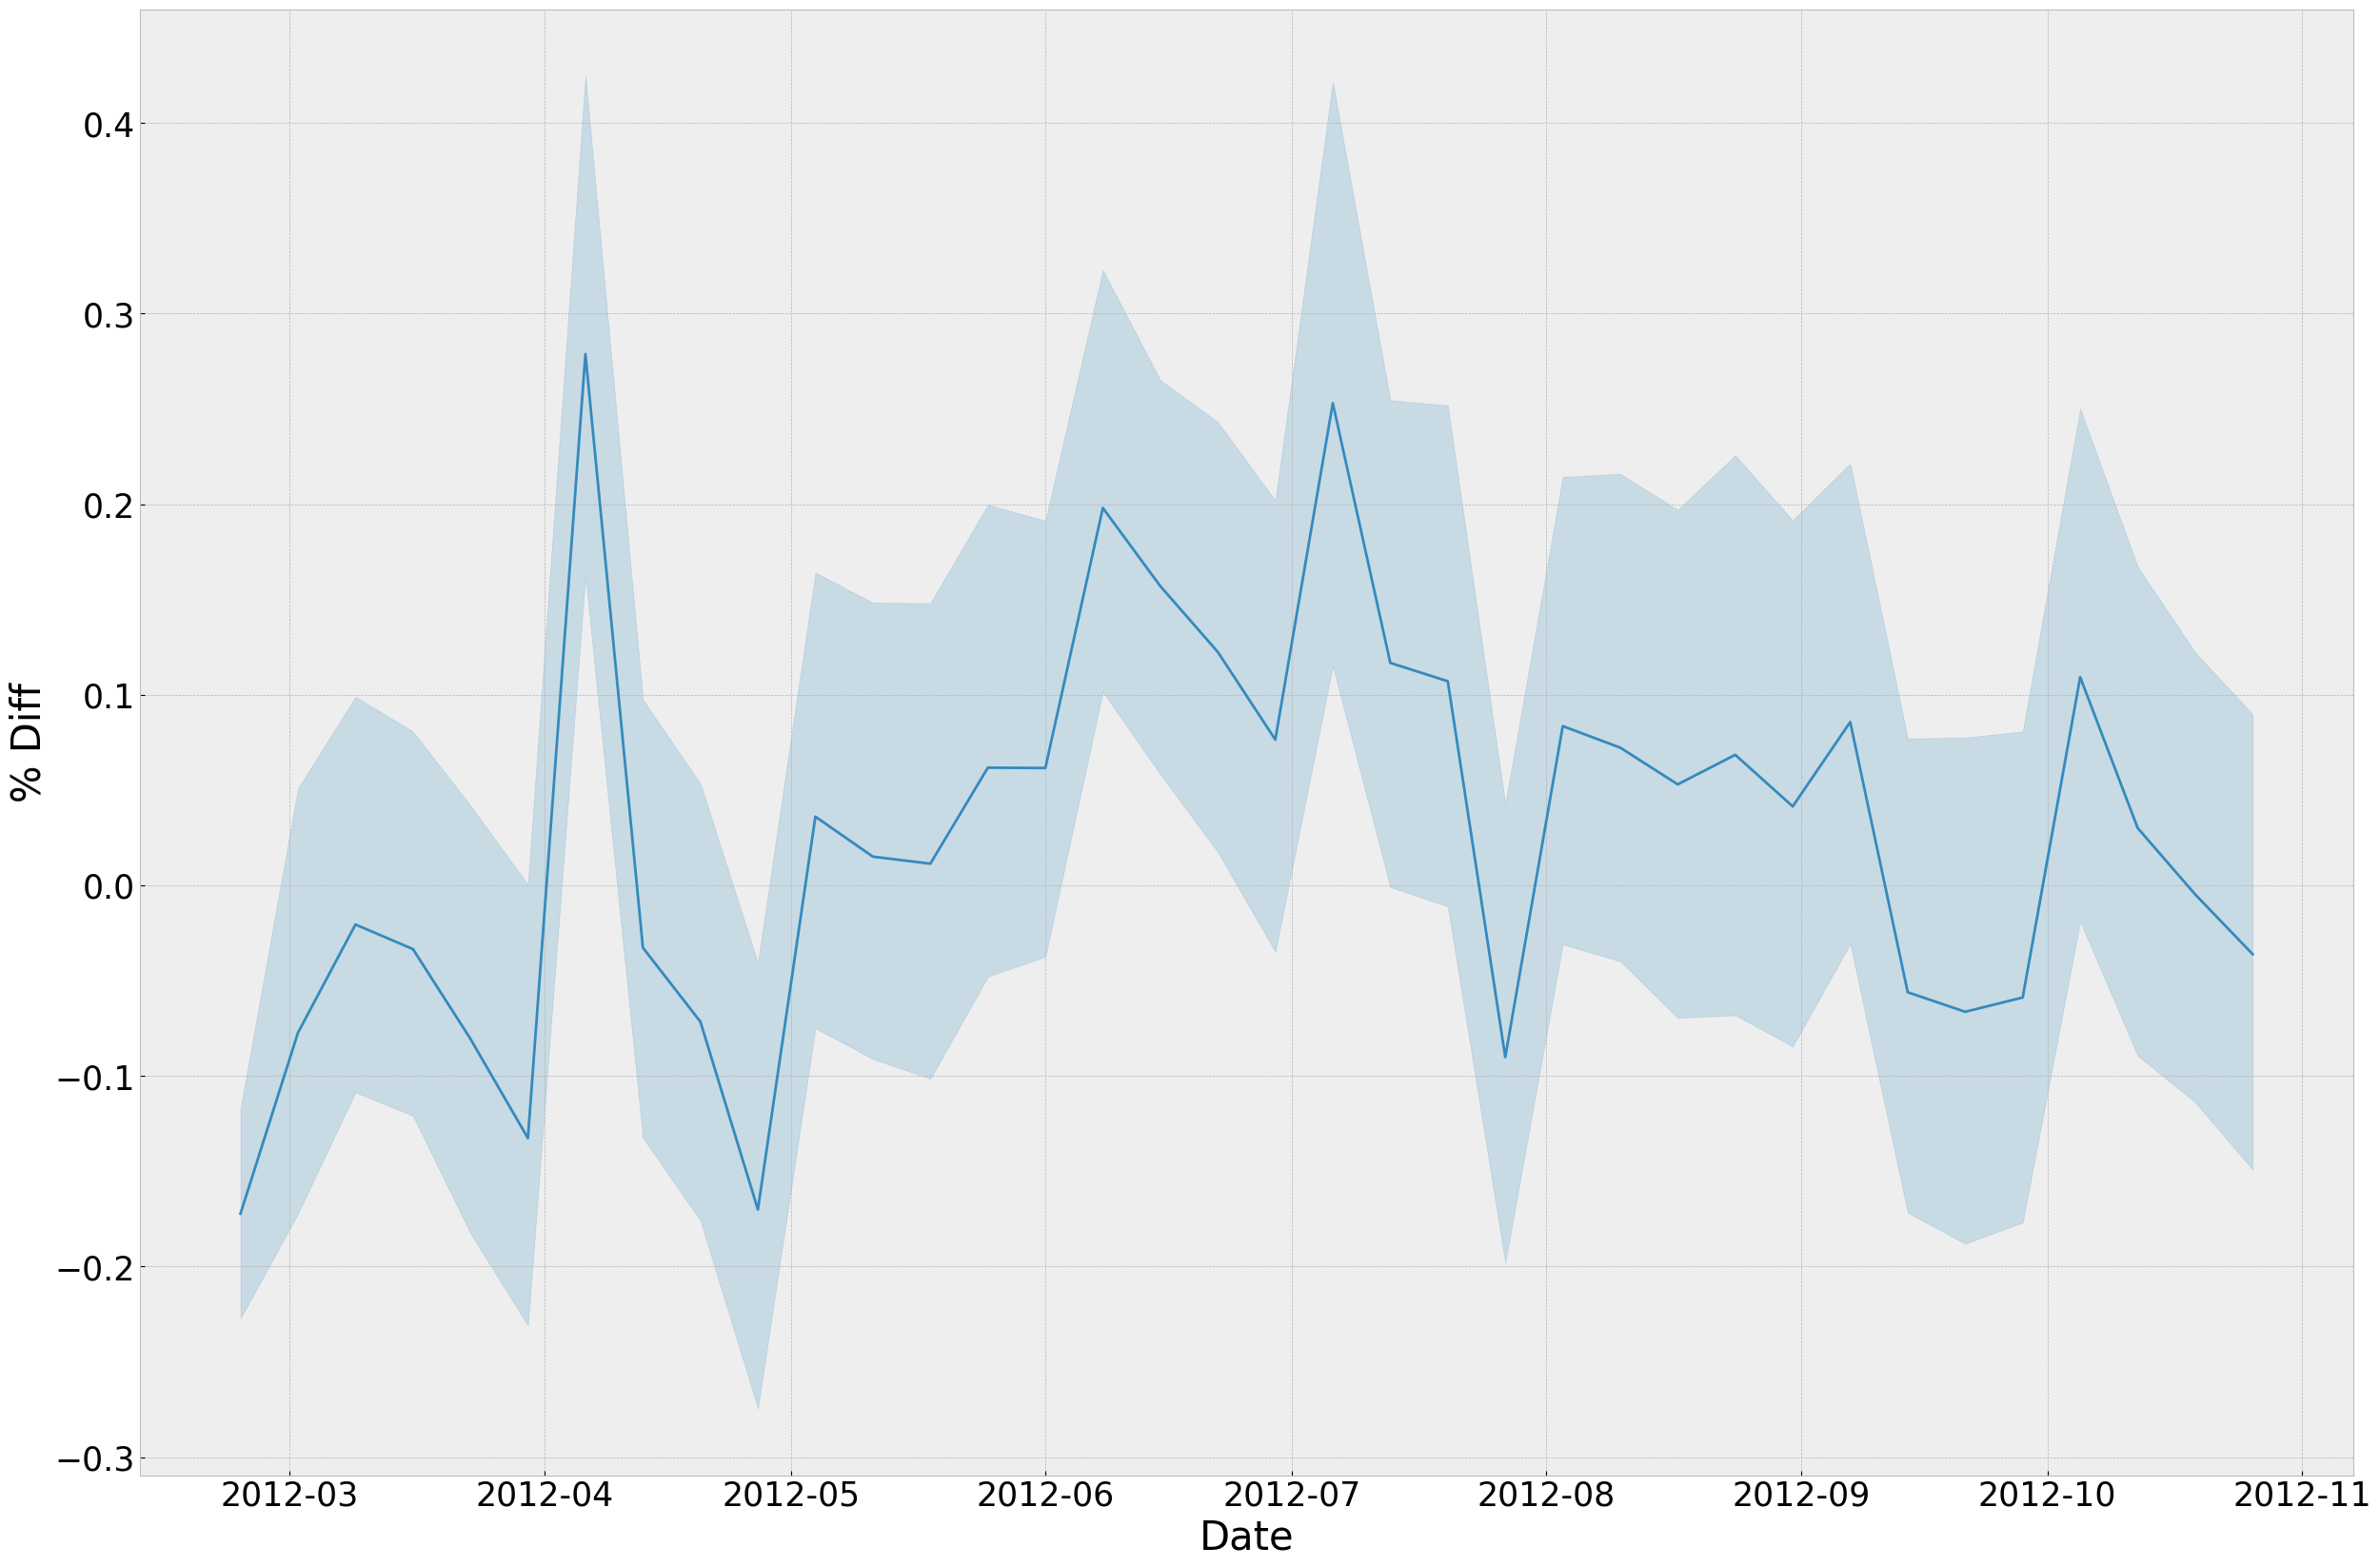

In [196]:
sns.lineplot(data=xtest, x='Date', y='% Diff')

In [ ]:
xgb_result['MAE']

In [ ]:
df3 = xtest
df3 = df3[['Store','Sales','Predictions_XGB']]

# MAE e MAPE
df_aux1 = df3[['Store', 'Sales', 'Predictions_XGB']].groupby('Store').apply(lambda x: mean_absolute_error(x['Sales'], x['Predictions_XGB'])).reset_index().rename(columns={0:'MAE'})
df_aux2 = df3[['Store', 'Sales', 'Predictions_XGB']].groupby('Store').apply(lambda x: mean_absolute_percentage_error(x['Sales'], x['Predictions_XGB'])).reset_index().rename(columns={0:'MAPE'})

df_aux3 = pd.merge(df_aux1,df_aux2, how='inner', on='Store')
df3 = pd.merge(df3, df_aux3, how='inner', on='Store')

# Scenarios
df3['worst_scenario'] = df3['Predictions_XGB'] - df3['MAE']
df3['best_scenario'] = df3['Predictions_XGB'] + df3['MAE']

In [ ]:
df3['% Diff'] = ((df3['Sales'] - df3['Predictions_XGB'])/df3['Sales'])*100
df3 = df3.drop(columns=['MAE','MAPE'])
df3

In [ ]:
df4 = df3[['Sales','Predictions_XGB','worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns= {'index': 'Scenario', 0: 'Values'})
df4['Values'] = df4['Values'].map('R${:,.2f}'.format)
df4